Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730016496.055469     109 service.cc:145] XLA service 0x7f145c02ba10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730016496.055548     109 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730016496.055554     109 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/281 ━━━━━━━━━━━━━━━━━━━━ 3:34:11 46s/step - accuracy: 0.1600 - loss: 2.1083

I0000 00:00:1730016517.040792     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step
Epoch 1: Precision: 0.1521, Recall: 0.1533, F1-Score: 0.1526, ROC AUC: 0.4920, Sensitivity: 0.1543, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.7833 - loss: 0.6540 - val_accuracy: 0.9113 - val_loss: 0.2470
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step
Epoch 2: Precision: 0.1785, Recall: 0.1767, F1-Score: 0.1770, ROC AUC: 0.5060, Sensitivity: 0.1763, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 182s 588ms/step - accuracy: 0.9099 - loss: 0.2545 - val_accuracy: 0.9047 - val_loss: 0.2429
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step
Epoch 3: Precision: 0.1662, Recall: 0.1670, F1-Score: 0.1665, ROC AUC: 0.5002, Sensitivity: 0.1661, Specificity: 0.0000
281/281 ━━━━━━━━━━━━━━━━━━━━ 170s 592ms/step - accuracy: 0.9196 - loss: 0.2266 - val_accuracy: 0.9173 - val_loss: 0.2191
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step
Epoch 4: Precision: 0.1683, Recall: 0.1680, F1-Score: 0.1680, ROC AUC: 0.5008, 

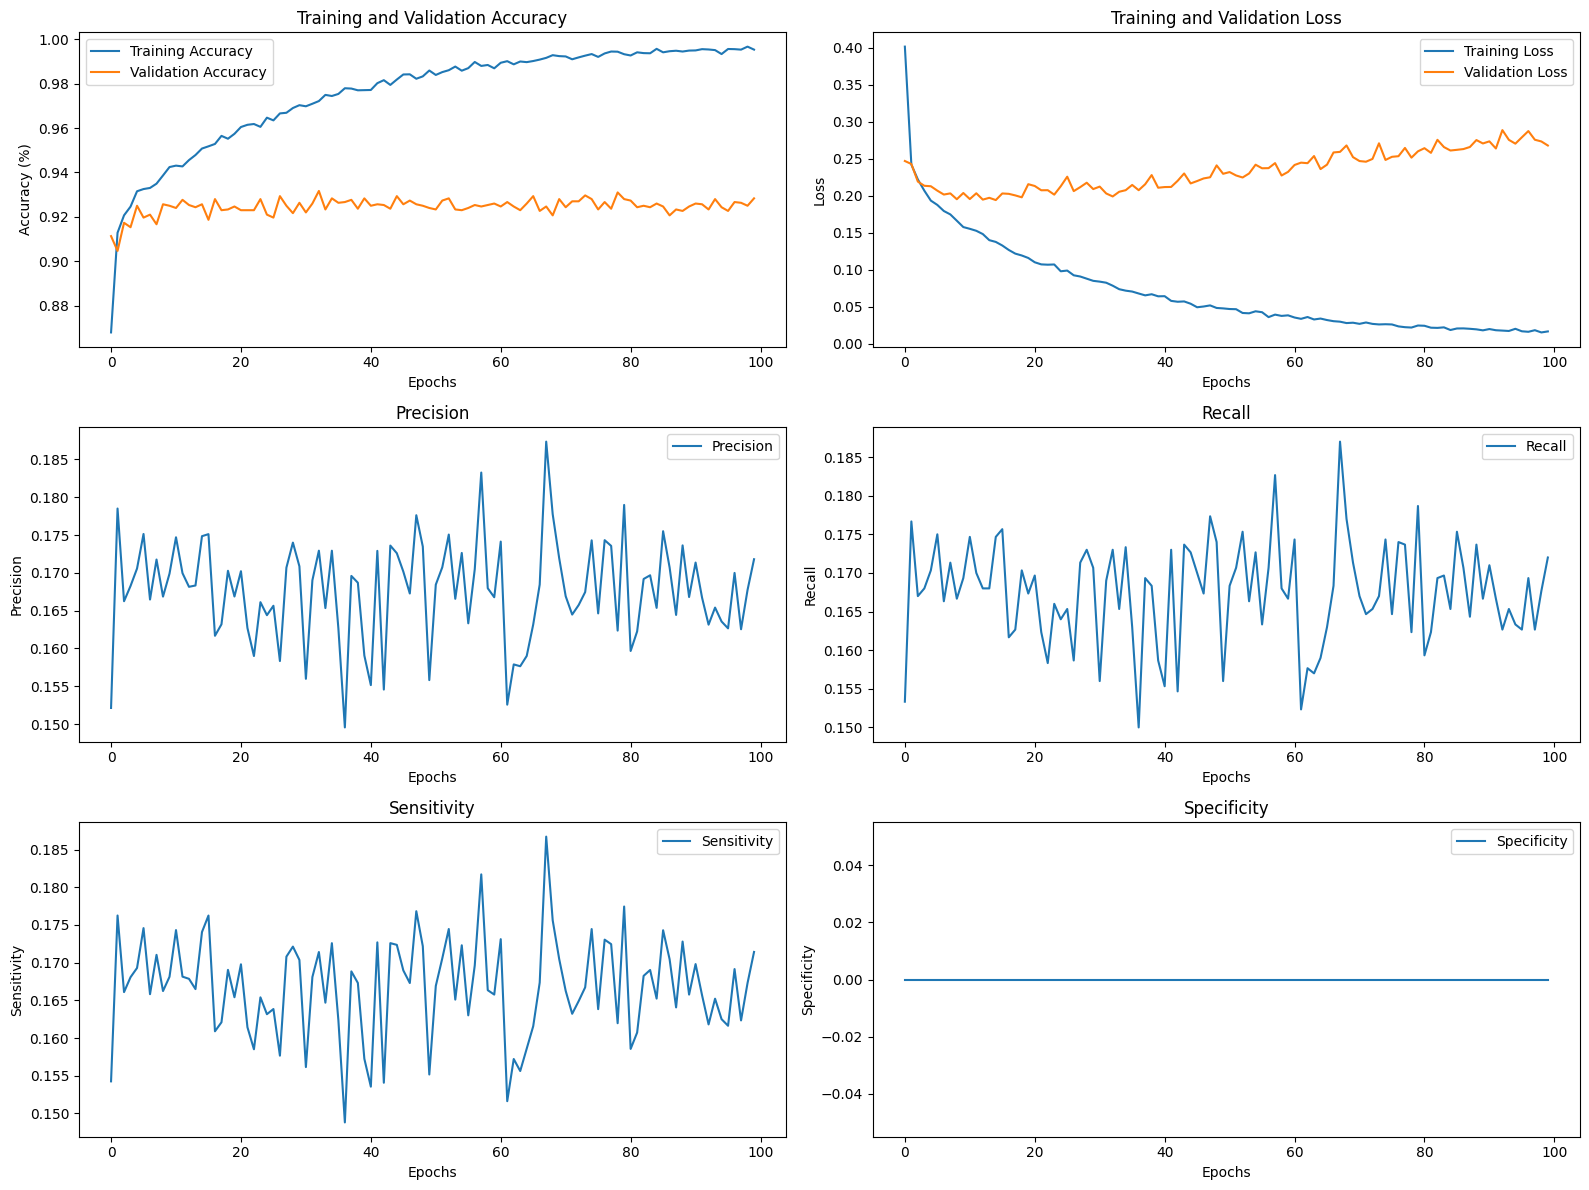

60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9254 - loss: 0.2791
Test Loss: 0.2679, Test Accuracy: 0.93%


In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import label_binarize
# Working on COLAB
train_data_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
test_data_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

img_size = (224, 224)  # Image size updated to 224x224
batch_size = 50
epochs = 100

# Create ImageDataGenerators for training and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Use 'train_data_path' to load training data
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Use 'test_data_path' to load test data
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model using pre-trained DenseNet169
base_model = tf.keras.applications.DenseNet169(
    include_top=False, 
    weights='imagenet', 
    input_shape=(224, 224, 3)
)

# Freeze the base model layers
base_model.trainable = False

# Build the custom model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save checkpoints during training
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'checkpoints/checkpointdense.keras', 
    save_best_only=True
)

# Custom callback to calculate additional metrics
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = np.argmax(self.model.predict(test_generator), axis=-1)
        val_labels = test_generator.classes

        val_labels_binarized = label_binarize(val_labels, classes=np.arange(len(test_generator.class_indices)))
        val_preds_binarized = label_binarize(val_preds, classes=np.arange(len(test_generator.class_indices)))

        precision = precision_score(val_labels, val_preds, average='weighted')
        recall = recall_score(val_labels, val_preds, average='weighted')
        f1 = f1_score(val_labels, val_preds, average='weighted')
        roc_auc = roc_auc_score(val_labels_binarized, val_preds_binarized, average='micro')

        cm = confusion_matrix(val_labels, val_preds)
        TN = np.diag(cm).sum() - np.trace(cm)
        FP = cm.sum(axis=0) - np.diag(cm)
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        specificity = np.mean(TN / (TN + FP + np.finfo(float).eps))
        sensitivity = np.mean(TP / (TP + FN + np.finfo(float).eps))

        print(f"Epoch {epoch+1}: Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC AUC: {roc_auc:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")

        if not hasattr(self, 'precision_list'):
            self.precision_list, self.recall_list, self.f1_list, self.roc_auc_list, self.sensitivity_list, self.specificity_list = [], [], [], [], [], []
        self.precision_list.append(precision)
        self.recall_list.append(recall)
        self.f1_list.append(f1)
        self.roc_auc_list.append(roc_auc)
        self.sensitivity_list.append(sensitivity)
        self.specificity_list.append(specificity)

metrics_callback = MetricsCallback()

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[checkpoint_cb, metrics_callback]
)

# Save the final model
model.save('best_model_densenet.h5')

# Plotting
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(metrics_callback.precision_list, label='Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(metrics_callback.recall_list, label='Recall')
plt.title('Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(metrics_callback.sensitivity_list, label='Sensitivity')
plt.title('Sensitivity')
plt.xlabel('Epochs')
plt.ylabel('Sensitivity')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(metrics_callback.specificity_list, label='Specificity')
plt.title('Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


/tmp/ipykernel_30/3414738843.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.6370, Accuracy: 0.3406, Precision: 0.3338, Recall: 0.3406, F1 Score: 0.3362, Specificity: 0.3339, Sensitivity: 0.3406
Validation Loss: 1.7957, Accuracy: 0.4633, Precision: 0.4917, Recall: 0.4633, F1 Score: 0.4545, Specificity: 0.4857, Sensitivity: 0.4633
Epoch 2/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5322, Accuracy: 0.3980, Precision: 0.4086, Recall: 0.3980, F1 Score: 0.3863, Specificity: 0.4085, Sensitivity: 0.3980
Validation Loss: 1.4543, Accuracy: 0.4807, Precision: 0.5052, Recall: 0.4807, F1 Score: 0.4755, Specificity: 0.5007, Sensitivity: 0.4807
Epoch 3/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5369, Accuracy: 0.3990, Precision: 0.4078, Recall: 0.3990, F1 Score: 0.3870, Specificity: 0.4077, Sensitivity: 0.3990
Validation Loss: 1.4188, Accuracy: 0.4887, Precision: 0.5120, Recall: 0.4887, F1 Score: 0.4825, Specificity: 0.5083, Sensitivity: 0.4887
Epoch 4/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5384, Accuracy: 0.4003, Precision: 0.4108, Recall: 0.4003, F1 Score: 0.3882, Specificity: 0.4106, Sensitivity: 0.4003
Validation Loss: 1.6543, Accuracy: 0.4753, Precision: 0.4968, Recall: 0.4753, F1 Score: 0.4713, Specificity: 0.4925, Sensitivity: 0.4753
Epoch 5/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5347, Accuracy: 0.4022, Precision: 0.4122, Recall: 0.4022, F1 Score: 0.3900, Specificity: 0.4121, Sensitivity: 0.4022
Validation Loss: 1.6036, Accuracy: 0.4743, Precision: 0.4981, Recall: 0.4743, F1 Score: 0.4689, Specificity: 0.4936, Sensitivity: 0.4743
Epoch 6/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5389, Accuracy: 0.3969, Precision: 0.4075, Recall: 0.3969, F1 Score: 0.3853, Specificity: 0.4073, Sensitivity: 0.3969
Validation Loss: 1.7164, Accuracy: 0.4737, Precision: 0.5004, Recall: 0.4737, F1 Score: 0.4684, Specificity: 0.4951, Sensitivity: 0.4737
Epoch 7/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5265, Accuracy: 0.4020, Precision: 0.4113, Recall: 0.4020, F1 Score: 0.3892, Specificity: 0.4113, Sensitivity: 0.4020
Validation Loss: 1.5717, Accuracy: 0.4790, Precision: 0.5044, Recall: 0.4790, F1 Score: 0.4733, Specificity: 0.4994, Sensitivity: 0.4790
Epoch 8/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5399, Accuracy: 0.4027, Precision: 0.4129, Recall: 0.4027, F1 Score: 0.3912, Specificity: 0.4128, Sensitivity: 0.4027
Validation Loss: 1.4801, Accuracy: 0.4827, Precision: 0.5026, Recall: 0.4827, F1 Score: 0.4777, Specificity: 0.4986, Sensitivity: 0.4827
Epoch 9/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5402, Accuracy: 0.4042, Precision: 0.4175, Recall: 0.4042, F1 Score: 0.3941, Specificity: 0.4178, Sensitivity: 0.4042
Validation Loss: 1.7985, Accuracy: 0.4697, Precision: 0.4976, Recall: 0.4697, F1 Score: 0.4649, Specificity: 0.4923, Sensitivity: 0.4697
Epoch 10/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5387, Accuracy: 0.4017, Precision: 0.4120, Recall: 0.4017, F1 Score: 0.3903, Specificity: 0.4118, Sensitivity: 0.4017
Validation Loss: 1.4722, Accuracy: 0.4807, Precision: 0.5001, Recall: 0.4807, F1 Score: 0.4754, Specificity: 0.4959, Sensitivity: 0.4807
Epoch 11/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5333, Accuracy: 0.4012, Precision: 0.4112, Recall: 0.4012, F1 Score: 0.3899, Specificity: 0.4112, Sensitivity: 0.4012
Validation Loss: 1.6631, Accuracy: 0.4783, Precision: 0.5064, Recall: 0.4783, F1 Score: 0.4726, Specificity: 0.5025, Sensitivity: 0.4783
Epoch 12/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5377, Accuracy: 0.4011, Precision: 0.4106, Recall: 0.4011, F1 Score: 0.3895, Specificity: 0.4105, Sensitivity: 0.4011
Validation Loss: 1.4701, Accuracy: 0.4870, Precision: 0.5079, Recall: 0.4870, F1 Score: 0.4791, Specificity: 0.5038, Sensitivity: 0.4870
Epoch 13/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5351, Accuracy: 0.4049, Precision: 0.4158, Recall: 0.4049, F1 Score: 0.3941, Specificity: 0.4157, Sensitivity: 0.4049
Validation Loss: 1.5281, Accuracy: 0.4823, Precision: 0.5041, Recall: 0.4823, F1 Score: 0.4766, Specificity: 0.5006, Sensitivity: 0.4823
Epoch 14/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5412, Accuracy: 0.3997, Precision: 0.4081, Recall: 0.3997, F1 Score: 0.3869, Specificity: 0.4080, Sensitivity: 0.3997
Validation Loss: 1.6100, Accuracy: 0.4750, Precision: 0.4991, Recall: 0.4750, F1 Score: 0.4700, Specificity: 0.4944, Sensitivity: 0.4750
Epoch 15/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5381, Accuracy: 0.4018, Precision: 0.4107, Recall: 0.4018, F1 Score: 0.3896, Specificity: 0.4106, Sensitivity: 0.4018
Validation Loss: 1.7606, Accuracy: 0.4727, Precision: 0.4961, Recall: 0.4727, F1 Score: 0.4677, Specificity: 0.4917, Sensitivity: 0.4727
Epoch 16/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5303, Accuracy: 0.4052, Precision: 0.4109, Recall: 0.4052, F1 Score: 0.3917, Specificity: 0.4107, Sensitivity: 0.4052
Validation Loss: 1.7317, Accuracy: 0.4717, Precision: 0.4991, Recall: 0.4717, F1 Score: 0.4671, Specificity: 0.4944, Sensitivity: 0.4717
Epoch 17/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5352, Accuracy: 0.3978, Precision: 0.4070, Recall: 0.3978, F1 Score: 0.3857, Specificity: 0.4070, Sensitivity: 0.3978
Validation Loss: 1.4959, Accuracy: 0.4790, Precision: 0.5030, Recall: 0.4790, F1 Score: 0.4730, Specificity: 0.4986, Sensitivity: 0.4790
Epoch 18/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5236, Accuracy: 0.4029, Precision: 0.4135, Recall: 0.4029, F1 Score: 0.3920, Specificity: 0.4135, Sensitivity: 0.4029
Validation Loss: 1.5626, Accuracy: 0.4757, Precision: 0.5019, Recall: 0.4757, F1 Score: 0.4696, Specificity: 0.4970, Sensitivity: 0.4757
Epoch 19/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5355, Accuracy: 0.3973, Precision: 0.4071, Recall: 0.3973, F1 Score: 0.3854, Specificity: 0.4069, Sensitivity: 0.3973
Validation Loss: 1.8210, Accuracy: 0.4663, Precision: 0.4925, Recall: 0.4663, F1 Score: 0.4612, Specificity: 0.4872, Sensitivity: 0.4663
Epoch 20/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5265, Accuracy: 0.4034, Precision: 0.4120, Recall: 0.4034, F1 Score: 0.3919, Specificity: 0.4123, Sensitivity: 0.4034
Validation Loss: 1.4666, Accuracy: 0.4833, Precision: 0.5031, Recall: 0.4833, F1 Score: 0.4783, Specificity: 0.4993, Sensitivity: 0.4833
Epoch 21/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5295, Accuracy: 0.4071, Precision: 0.4179, Recall: 0.4071, F1 Score: 0.3950, Specificity: 0.4181, Sensitivity: 0.4071
Validation Loss: 1.5915, Accuracy: 0.4740, Precision: 0.5002, Recall: 0.4740, F1 Score: 0.4683, Specificity: 0.4959, Sensitivity: 0.4740
Epoch 22/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5385, Accuracy: 0.3978, Precision: 0.4057, Recall: 0.3978, F1 Score: 0.3861, Specificity: 0.4053, Sensitivity: 0.3978
Validation Loss: 1.6146, Accuracy: 0.4717, Precision: 0.4942, Recall: 0.4717, F1 Score: 0.4647, Specificity: 0.4898, Sensitivity: 0.4717
Epoch 23/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5233, Accuracy: 0.4043, Precision: 0.4152, Recall: 0.4043, F1 Score: 0.3929, Specificity: 0.4154, Sensitivity: 0.4043
Validation Loss: 1.6616, Accuracy: 0.4763, Precision: 0.4997, Recall: 0.4763, F1 Score: 0.4680, Specificity: 0.4945, Sensitivity: 0.4763
Epoch 24/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5267, Accuracy: 0.4054, Precision: 0.4162, Recall: 0.4054, F1 Score: 0.3946, Specificity: 0.4162, Sensitivity: 0.4054
Validation Loss: 1.6194, Accuracy: 0.4743, Precision: 0.4991, Recall: 0.4743, F1 Score: 0.4694, Specificity: 0.4948, Sensitivity: 0.4743
Epoch 25/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5257, Accuracy: 0.4041, Precision: 0.4145, Recall: 0.4041, F1 Score: 0.3927, Specificity: 0.4145, Sensitivity: 0.4041
Validation Loss: 1.5297, Accuracy: 0.4747, Precision: 0.4993, Recall: 0.4747, F1 Score: 0.4685, Specificity: 0.4950, Sensitivity: 0.4747
Epoch 26/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5190, Accuracy: 0.4116, Precision: 0.4254, Recall: 0.4116, F1 Score: 0.4001, Specificity: 0.4255, Sensitivity: 0.4116
Validation Loss: 1.7213, Accuracy: 0.4697, Precision: 0.4947, Recall: 0.4697, F1 Score: 0.4631, Specificity: 0.4899, Sensitivity: 0.4697
Epoch 27/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5361, Accuracy: 0.4048, Precision: 0.4161, Recall: 0.4048, F1 Score: 0.3940, Specificity: 0.4161, Sensitivity: 0.4048
Validation Loss: 1.5468, Accuracy: 0.4733, Precision: 0.4956, Recall: 0.4733, F1 Score: 0.4661, Specificity: 0.4901, Sensitivity: 0.4733
Epoch 28/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5430, Accuracy: 0.3965, Precision: 0.4082, Recall: 0.3965, F1 Score: 0.3854, Specificity: 0.4082, Sensitivity: 0.3965
Validation Loss: 1.7261, Accuracy: 0.4650, Precision: 0.4927, Recall: 0.4650, F1 Score: 0.4599, Specificity: 0.4872, Sensitivity: 0.4650
Epoch 29/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5423, Accuracy: 0.4059, Precision: 0.4159, Recall: 0.4059, F1 Score: 0.3940, Specificity: 0.4159, Sensitivity: 0.4059
Validation Loss: 1.4711, Accuracy: 0.4867, Precision: 0.5089, Recall: 0.4867, F1 Score: 0.4818, Specificity: 0.5050, Sensitivity: 0.4867
Epoch 30/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5365, Accuracy: 0.4012, Precision: 0.4106, Recall: 0.4012, F1 Score: 0.3898, Specificity: 0.4108, Sensitivity: 0.4012
Validation Loss: 1.7326, Accuracy: 0.4713, Precision: 0.4950, Recall: 0.4713, F1 Score: 0.4648, Specificity: 0.4904, Sensitivity: 0.4713
Epoch 31/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5345, Accuracy: 0.4079, Precision: 0.4194, Recall: 0.4079, F1 Score: 0.3966, Specificity: 0.4195, Sensitivity: 0.4079
Validation Loss: 1.5009, Accuracy: 0.4780, Precision: 0.5033, Recall: 0.4780, F1 Score: 0.4724, Specificity: 0.4984, Sensitivity: 0.4780
Epoch 32/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5318, Accuracy: 0.4005, Precision: 0.4096, Recall: 0.4005, F1 Score: 0.3886, Specificity: 0.4095, Sensitivity: 0.4005
Validation Loss: 1.5035, Accuracy: 0.4697, Precision: 0.4912, Recall: 0.4697, F1 Score: 0.4635, Specificity: 0.4868, Sensitivity: 0.4697
Epoch 33/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5333, Accuracy: 0.4025, Precision: 0.4135, Recall: 0.4025, F1 Score: 0.3917, Specificity: 0.4137, Sensitivity: 0.4025
Validation Loss: 1.4929, Accuracy: 0.4770, Precision: 0.4979, Recall: 0.4770, F1 Score: 0.4716, Specificity: 0.4939, Sensitivity: 0.4770
Epoch 34/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5230, Accuracy: 0.4032, Precision: 0.4135, Recall: 0.4032, F1 Score: 0.3914, Specificity: 0.4134, Sensitivity: 0.4032
Validation Loss: 1.4592, Accuracy: 0.4827, Precision: 0.5021, Recall: 0.4827, F1 Score: 0.4772, Specificity: 0.4980, Sensitivity: 0.4827
Epoch 35/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5194, Accuracy: 0.4062, Precision: 0.4161, Recall: 0.4062, F1 Score: 0.3939, Specificity: 0.4159, Sensitivity: 0.4062
Validation Loss: 1.4750, Accuracy: 0.4857, Precision: 0.5052, Recall: 0.4857, F1 Score: 0.4792, Specificity: 0.5014, Sensitivity: 0.4857
Epoch 36/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5238, Accuracy: 0.4019, Precision: 0.4115, Recall: 0.4019, F1 Score: 0.3892, Specificity: 0.4115, Sensitivity: 0.4019
Validation Loss: 1.6371, Accuracy: 0.4703, Precision: 0.4953, Recall: 0.4703, F1 Score: 0.4653, Specificity: 0.4903, Sensitivity: 0.4703
Epoch 37/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5245, Accuracy: 0.4040, Precision: 0.4138, Recall: 0.4040, F1 Score: 0.3922, Specificity: 0.4138, Sensitivity: 0.4040
Validation Loss: 1.4468, Accuracy: 0.4803, Precision: 0.5006, Recall: 0.4803, F1 Score: 0.4747, Specificity: 0.4961, Sensitivity: 0.4803
Epoch 38/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5200, Accuracy: 0.4039, Precision: 0.4148, Recall: 0.4039, F1 Score: 0.3921, Specificity: 0.4148, Sensitivity: 0.4039
Validation Loss: 1.4677, Accuracy: 0.4790, Precision: 0.5010, Recall: 0.4790, F1 Score: 0.4749, Specificity: 0.4965, Sensitivity: 0.4790
Epoch 39/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5390, Accuracy: 0.3936, Precision: 0.4047, Recall: 0.3936, F1 Score: 0.3825, Specificity: 0.4047, Sensitivity: 0.3936
Validation Loss: 1.5814, Accuracy: 0.4813, Precision: 0.5083, Recall: 0.4813, F1 Score: 0.4750, Specificity: 0.5039, Sensitivity: 0.4813
Epoch 40/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5365, Accuracy: 0.3995, Precision: 0.4071, Recall: 0.3995, F1 Score: 0.3873, Specificity: 0.4070, Sensitivity: 0.3995
Validation Loss: 1.4740, Accuracy: 0.4800, Precision: 0.5039, Recall: 0.4800, F1 Score: 0.4740, Specificity: 0.4992, Sensitivity: 0.4800
Epoch 41/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5340, Accuracy: 0.4040, Precision: 0.4148, Recall: 0.4040, F1 Score: 0.3925, Specificity: 0.4148, Sensitivity: 0.4040
Validation Loss: 1.5724, Accuracy: 0.4743, Precision: 0.5004, Recall: 0.4743, F1 Score: 0.4706, Specificity: 0.4959, Sensitivity: 0.4743
Epoch 42/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5498, Accuracy: 0.3983, Precision: 0.4069, Recall: 0.3983, F1 Score: 0.3860, Specificity: 0.4065, Sensitivity: 0.3983
Validation Loss: 1.5854, Accuracy: 0.4727, Precision: 0.4972, Recall: 0.4727, F1 Score: 0.4674, Specificity: 0.4925, Sensitivity: 0.4727
Epoch 43/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5316, Accuracy: 0.4067, Precision: 0.4189, Recall: 0.4067, F1 Score: 0.3957, Specificity: 0.4189, Sensitivity: 0.4067
Validation Loss: 1.5852, Accuracy: 0.4740, Precision: 0.5047, Recall: 0.4740, F1 Score: 0.4702, Specificity: 0.5001, Sensitivity: 0.4740
Epoch 44/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5442, Accuracy: 0.4006, Precision: 0.4126, Recall: 0.4006, F1 Score: 0.3890, Specificity: 0.4126, Sensitivity: 0.4006
Validation Loss: 1.5737, Accuracy: 0.4700, Precision: 0.4962, Recall: 0.4700, F1 Score: 0.4640, Specificity: 0.4911, Sensitivity: 0.4700
Epoch 45/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5326, Accuracy: 0.3948, Precision: 0.4037, Recall: 0.3948, F1 Score: 0.3828, Specificity: 0.4034, Sensitivity: 0.3948
Validation Loss: 1.4286, Accuracy: 0.4850, Precision: 0.5039, Recall: 0.4850, F1 Score: 0.4786, Specificity: 0.4995, Sensitivity: 0.4850
Epoch 46/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5454, Accuracy: 0.4028, Precision: 0.4130, Recall: 0.4028, F1 Score: 0.3913, Specificity: 0.4131, Sensitivity: 0.4028
Validation Loss: 1.6015, Accuracy: 0.4733, Precision: 0.4970, Recall: 0.4733, F1 Score: 0.4672, Specificity: 0.4923, Sensitivity: 0.4733
Epoch 47/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5334, Accuracy: 0.4058, Precision: 0.4176, Recall: 0.4058, F1 Score: 0.3943, Specificity: 0.4177, Sensitivity: 0.4058
Validation Loss: 1.4726, Accuracy: 0.4763, Precision: 0.5003, Recall: 0.4763, F1 Score: 0.4688, Specificity: 0.4952, Sensitivity: 0.4763
Epoch 48/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5457, Accuracy: 0.3991, Precision: 0.4099, Recall: 0.3991, F1 Score: 0.3885, Specificity: 0.4100, Sensitivity: 0.3991
Validation Loss: 1.5731, Accuracy: 0.4710, Precision: 0.4919, Recall: 0.4710, F1 Score: 0.4655, Specificity: 0.4873, Sensitivity: 0.4710
Epoch 49/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5338, Accuracy: 0.4021, Precision: 0.4133, Recall: 0.4021, F1 Score: 0.3903, Specificity: 0.4133, Sensitivity: 0.4021
Validation Loss: 1.5994, Accuracy: 0.4723, Precision: 0.4939, Recall: 0.4723, F1 Score: 0.4659, Specificity: 0.4895, Sensitivity: 0.4723
Epoch 50/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5282, Accuracy: 0.3990, Precision: 0.4067, Recall: 0.3990, F1 Score: 0.3866, Specificity: 0.4064, Sensitivity: 0.3990
Validation Loss: 1.4556, Accuracy: 0.4783, Precision: 0.5030, Recall: 0.4783, F1 Score: 0.4716, Specificity: 0.4983, Sensitivity: 0.4783
Epoch 51/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5391, Accuracy: 0.4017, Precision: 0.4116, Recall: 0.4017, F1 Score: 0.3900, Specificity: 0.4115, Sensitivity: 0.4017
Validation Loss: 1.5937, Accuracy: 0.4753, Precision: 0.4965, Recall: 0.4753, F1 Score: 0.4699, Specificity: 0.4922, Sensitivity: 0.4753
Epoch 52/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5335, Accuracy: 0.4001, Precision: 0.4092, Recall: 0.4001, F1 Score: 0.3880, Specificity: 0.4088, Sensitivity: 0.4001
Validation Loss: 1.5479, Accuracy: 0.4797, Precision: 0.5029, Recall: 0.4797, F1 Score: 0.4746, Specificity: 0.4990, Sensitivity: 0.4797
Epoch 53/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5257, Accuracy: 0.3982, Precision: 0.4085, Recall: 0.3982, F1 Score: 0.3868, Specificity: 0.4083, Sensitivity: 0.3982
Validation Loss: 1.3913, Accuracy: 0.4860, Precision: 0.5065, Recall: 0.4860, F1 Score: 0.4803, Specificity: 0.5022, Sensitivity: 0.4860
Epoch 54/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5386, Accuracy: 0.4035, Precision: 0.4138, Recall: 0.4035, F1 Score: 0.3919, Specificity: 0.4138, Sensitivity: 0.4035
Validation Loss: 1.5580, Accuracy: 0.4783, Precision: 0.5049, Recall: 0.4783, F1 Score: 0.4747, Specificity: 0.5008, Sensitivity: 0.4783
Epoch 55/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5322, Accuracy: 0.3981, Precision: 0.4082, Recall: 0.3981, F1 Score: 0.3868, Specificity: 0.4083, Sensitivity: 0.3981
Validation Loss: 1.5511, Accuracy: 0.4740, Precision: 0.5003, Recall: 0.4740, F1 Score: 0.4706, Specificity: 0.4960, Sensitivity: 0.4740
Epoch 56/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5239, Accuracy: 0.4034, Precision: 0.4149, Recall: 0.4034, F1 Score: 0.3924, Specificity: 0.4149, Sensitivity: 0.4034
Validation Loss: 1.5122, Accuracy: 0.4770, Precision: 0.4996, Recall: 0.4770, F1 Score: 0.4727, Specificity: 0.4952, Sensitivity: 0.4770
Epoch 57/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5301, Accuracy: 0.4029, Precision: 0.4138, Recall: 0.4029, F1 Score: 0.3913, Specificity: 0.4139, Sensitivity: 0.4029
Validation Loss: 1.4189, Accuracy: 0.4810, Precision: 0.4989, Recall: 0.4810, F1 Score: 0.4752, Specificity: 0.4943, Sensitivity: 0.4810
Epoch 58/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5405, Accuracy: 0.4017, Precision: 0.4099, Recall: 0.4017, F1 Score: 0.3895, Specificity: 0.4096, Sensitivity: 0.4017
Validation Loss: 1.7862, Accuracy: 0.4700, Precision: 0.4941, Recall: 0.4700, F1 Score: 0.4645, Specificity: 0.4897, Sensitivity: 0.4700
Epoch 59/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5309, Accuracy: 0.4036, Precision: 0.4125, Recall: 0.4036, F1 Score: 0.3912, Specificity: 0.4124, Sensitivity: 0.4036
Validation Loss: 1.4700, Accuracy: 0.4767, Precision: 0.5041, Recall: 0.4767, F1 Score: 0.4727, Specificity: 0.4994, Sensitivity: 0.4767
Epoch 60/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5391, Accuracy: 0.4002, Precision: 0.4100, Recall: 0.4002, F1 Score: 0.3877, Specificity: 0.4099, Sensitivity: 0.4002
Validation Loss: 1.4461, Accuracy: 0.4810, Precision: 0.5025, Recall: 0.4810, F1 Score: 0.4763, Specificity: 0.4980, Sensitivity: 0.4810
Epoch 61/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5469, Accuracy: 0.4037, Precision: 0.4110, Recall: 0.4037, F1 Score: 0.3912, Specificity: 0.4110, Sensitivity: 0.4037
Validation Loss: 1.4168, Accuracy: 0.4837, Precision: 0.5076, Recall: 0.4837, F1 Score: 0.4808, Specificity: 0.5036, Sensitivity: 0.4837
Epoch 62/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5257, Accuracy: 0.4036, Precision: 0.4135, Recall: 0.4036, F1 Score: 0.3919, Specificity: 0.4135, Sensitivity: 0.4036
Validation Loss: 1.4770, Accuracy: 0.4813, Precision: 0.5040, Recall: 0.4813, F1 Score: 0.4773, Specificity: 0.5003, Sensitivity: 0.4813
Epoch 63/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5312, Accuracy: 0.4023, Precision: 0.4115, Recall: 0.4023, F1 Score: 0.3898, Specificity: 0.4116, Sensitivity: 0.4023
Validation Loss: 1.5524, Accuracy: 0.4787, Precision: 0.5059, Recall: 0.4787, F1 Score: 0.4729, Specificity: 0.5018, Sensitivity: 0.4787
Epoch 64/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5289, Accuracy: 0.4033, Precision: 0.4141, Recall: 0.4033, F1 Score: 0.3922, Specificity: 0.4142, Sensitivity: 0.4033
Validation Loss: 1.5758, Accuracy: 0.4757, Precision: 0.4982, Recall: 0.4757, F1 Score: 0.4706, Specificity: 0.4944, Sensitivity: 0.4757
Epoch 65/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5316, Accuracy: 0.4055, Precision: 0.4175, Recall: 0.4055, F1 Score: 0.3937, Specificity: 0.4177, Sensitivity: 0.4055
Validation Loss: 1.5624, Accuracy: 0.4787, Precision: 0.5043, Recall: 0.4787, F1 Score: 0.4746, Specificity: 0.4996, Sensitivity: 0.4787
Epoch 66/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5458, Accuracy: 0.3985, Precision: 0.4073, Recall: 0.3985, F1 Score: 0.3857, Specificity: 0.4073, Sensitivity: 0.3985
Validation Loss: 1.6355, Accuracy: 0.4730, Precision: 0.4967, Recall: 0.4730, F1 Score: 0.4674, Specificity: 0.4919, Sensitivity: 0.4730
Epoch 67/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5299, Accuracy: 0.4017, Precision: 0.4141, Recall: 0.4017, F1 Score: 0.3906, Specificity: 0.4142, Sensitivity: 0.4017
Validation Loss: 1.5310, Accuracy: 0.4807, Precision: 0.5060, Recall: 0.4807, F1 Score: 0.4744, Specificity: 0.5013, Sensitivity: 0.4807
Epoch 68/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5478, Accuracy: 0.3975, Precision: 0.4084, Recall: 0.3975, F1 Score: 0.3865, Specificity: 0.4084, Sensitivity: 0.3975
Validation Loss: 1.5671, Accuracy: 0.4723, Precision: 0.4958, Recall: 0.4723, F1 Score: 0.4678, Specificity: 0.4906, Sensitivity: 0.4723
Epoch 69/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5314, Accuracy: 0.4009, Precision: 0.4109, Recall: 0.4009, F1 Score: 0.3886, Specificity: 0.4107, Sensitivity: 0.4009
Validation Loss: 1.5893, Accuracy: 0.4757, Precision: 0.4999, Recall: 0.4757, F1 Score: 0.4699, Specificity: 0.4949, Sensitivity: 0.4757
Epoch 70/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5406, Accuracy: 0.3950, Precision: 0.4049, Recall: 0.3950, F1 Score: 0.3833, Specificity: 0.4049, Sensitivity: 0.3950
Validation Loss: 1.7131, Accuracy: 0.4650, Precision: 0.4931, Recall: 0.4650, F1 Score: 0.4577, Specificity: 0.4870, Sensitivity: 0.4650
Epoch 71/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5368, Accuracy: 0.3982, Precision: 0.4070, Recall: 0.3982, F1 Score: 0.3859, Specificity: 0.4068, Sensitivity: 0.3982
Validation Loss: 1.7167, Accuracy: 0.4743, Precision: 0.4975, Recall: 0.4743, F1 Score: 0.4683, Specificity: 0.4929, Sensitivity: 0.4743
Epoch 72/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5320, Accuracy: 0.4034, Precision: 0.4134, Recall: 0.4034, F1 Score: 0.3912, Specificity: 0.4133, Sensitivity: 0.4034
Validation Loss: 1.4122, Accuracy: 0.4773, Precision: 0.4961, Recall: 0.4773, F1 Score: 0.4728, Specificity: 0.4920, Sensitivity: 0.4773
Epoch 73/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5328, Accuracy: 0.4027, Precision: 0.4138, Recall: 0.4027, F1 Score: 0.3914, Specificity: 0.4139, Sensitivity: 0.4027
Validation Loss: 1.6469, Accuracy: 0.4670, Precision: 0.4922, Recall: 0.4670, F1 Score: 0.4614, Specificity: 0.4868, Sensitivity: 0.4670
Epoch 74/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5267, Accuracy: 0.4042, Precision: 0.4121, Recall: 0.4042, F1 Score: 0.3912, Specificity: 0.4120, Sensitivity: 0.4042
Validation Loss: 1.5326, Accuracy: 0.4717, Precision: 0.4987, Recall: 0.4717, F1 Score: 0.4669, Specificity: 0.4936, Sensitivity: 0.4717
Epoch 75/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5368, Accuracy: 0.4074, Precision: 0.4151, Recall: 0.4074, F1 Score: 0.3948, Specificity: 0.4150, Sensitivity: 0.4074
Validation Loss: 1.5533, Accuracy: 0.4770, Precision: 0.5026, Recall: 0.4770, F1 Score: 0.4718, Specificity: 0.4982, Sensitivity: 0.4770
Epoch 76/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5298, Accuracy: 0.4044, Precision: 0.4149, Recall: 0.4044, F1 Score: 0.3923, Specificity: 0.4149, Sensitivity: 0.4044
Validation Loss: 1.6137, Accuracy: 0.4737, Precision: 0.4977, Recall: 0.4737, F1 Score: 0.4697, Specificity: 0.4931, Sensitivity: 0.4737
Epoch 77/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5214, Accuracy: 0.3985, Precision: 0.4078, Recall: 0.3985, F1 Score: 0.3870, Specificity: 0.4079, Sensitivity: 0.3985
Validation Loss: 1.5168, Accuracy: 0.4640, Precision: 0.4873, Recall: 0.4640, F1 Score: 0.4582, Specificity: 0.4823, Sensitivity: 0.4640
Epoch 78/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5236, Accuracy: 0.4059, Precision: 0.4155, Recall: 0.4059, F1 Score: 0.3937, Specificity: 0.4155, Sensitivity: 0.4059
Validation Loss: 1.4044, Accuracy: 0.4820, Precision: 0.5028, Recall: 0.4820, F1 Score: 0.4765, Specificity: 0.4983, Sensitivity: 0.4820
Epoch 79/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5367, Accuracy: 0.4020, Precision: 0.4107, Recall: 0.4020, F1 Score: 0.3897, Specificity: 0.4106, Sensitivity: 0.4020
Validation Loss: 1.6107, Accuracy: 0.4703, Precision: 0.5007, Recall: 0.4703, F1 Score: 0.4659, Specificity: 0.4957, Sensitivity: 0.4703
Epoch 80/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5229, Accuracy: 0.4046, Precision: 0.4156, Recall: 0.4046, F1 Score: 0.3934, Specificity: 0.4156, Sensitivity: 0.4046
Validation Loss: 1.4641, Accuracy: 0.4800, Precision: 0.5001, Recall: 0.4800, F1 Score: 0.4744, Specificity: 0.4960, Sensitivity: 0.4800
Epoch 81/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5347, Accuracy: 0.4027, Precision: 0.4139, Recall: 0.4027, F1 Score: 0.3917, Specificity: 0.4139, Sensitivity: 0.4027
Validation Loss: 1.4765, Accuracy: 0.4737, Precision: 0.4962, Recall: 0.4737, F1 Score: 0.4684, Specificity: 0.4921, Sensitivity: 0.4737
Epoch 82/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5470, Accuracy: 0.3995, Precision: 0.4089, Recall: 0.3995, F1 Score: 0.3872, Specificity: 0.4088, Sensitivity: 0.3995
Validation Loss: 1.5062, Accuracy: 0.4837, Precision: 0.5059, Recall: 0.4837, F1 Score: 0.4777, Specificity: 0.5022, Sensitivity: 0.4837
Epoch 83/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5428, Accuracy: 0.4017, Precision: 0.4128, Recall: 0.4017, F1 Score: 0.3893, Specificity: 0.4129, Sensitivity: 0.4017
Validation Loss: 1.6566, Accuracy: 0.4717, Precision: 0.5009, Recall: 0.4717, F1 Score: 0.4664, Specificity: 0.4959, Sensitivity: 0.4717
Epoch 84/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5327, Accuracy: 0.3998, Precision: 0.4080, Recall: 0.3998, F1 Score: 0.3874, Specificity: 0.4079, Sensitivity: 0.3998
Validation Loss: 1.4580, Accuracy: 0.4807, Precision: 0.5017, Recall: 0.4807, F1 Score: 0.4754, Specificity: 0.4975, Sensitivity: 0.4807
Epoch 85/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5333, Accuracy: 0.4012, Precision: 0.4114, Recall: 0.4012, F1 Score: 0.3891, Specificity: 0.4112, Sensitivity: 0.4012
Validation Loss: 1.7290, Accuracy: 0.4713, Precision: 0.4940, Recall: 0.4713, F1 Score: 0.4629, Specificity: 0.4893, Sensitivity: 0.4713
Epoch 86/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5341, Accuracy: 0.4019, Precision: 0.4120, Recall: 0.4019, F1 Score: 0.3902, Specificity: 0.4120, Sensitivity: 0.4019
Validation Loss: 1.4994, Accuracy: 0.4723, Precision: 0.4943, Recall: 0.4723, F1 Score: 0.4667, Specificity: 0.4894, Sensitivity: 0.4723
Epoch 87/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5266, Accuracy: 0.4044, Precision: 0.4139, Recall: 0.4044, F1 Score: 0.3927, Specificity: 0.4138, Sensitivity: 0.4044
Validation Loss: 1.5046, Accuracy: 0.4817, Precision: 0.5012, Recall: 0.4817, F1 Score: 0.4758, Specificity: 0.4967, Sensitivity: 0.4817
Epoch 88/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5314, Accuracy: 0.4074, Precision: 0.4200, Recall: 0.4074, F1 Score: 0.3964, Specificity: 0.4200, Sensitivity: 0.4074
Validation Loss: 1.5001, Accuracy: 0.4787, Precision: 0.5065, Recall: 0.4787, F1 Score: 0.4753, Specificity: 0.5019, Sensitivity: 0.4787
Epoch 89/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5172, Accuracy: 0.4028, Precision: 0.4130, Recall: 0.4028, F1 Score: 0.3904, Specificity: 0.4130, Sensitivity: 0.4028
Validation Loss: 1.4341, Accuracy: 0.4843, Precision: 0.5046, Recall: 0.4843, F1 Score: 0.4781, Specificity: 0.5012, Sensitivity: 0.4843
Epoch 90/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5353, Accuracy: 0.3994, Precision: 0.4105, Recall: 0.3994, F1 Score: 0.3879, Specificity: 0.4103, Sensitivity: 0.3994
Validation Loss: 1.4832, Accuracy: 0.4820, Precision: 0.5059, Recall: 0.4820, F1 Score: 0.4771, Specificity: 0.5011, Sensitivity: 0.4820
Epoch 91/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5353, Accuracy: 0.4073, Precision: 0.4176, Recall: 0.4073, F1 Score: 0.3953, Specificity: 0.4176, Sensitivity: 0.4073
Validation Loss: 1.8033, Accuracy: 0.4673, Precision: 0.4979, Recall: 0.4673, F1 Score: 0.4633, Specificity: 0.4932, Sensitivity: 0.4673
Epoch 92/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5323, Accuracy: 0.3969, Precision: 0.4070, Recall: 0.3969, F1 Score: 0.3852, Specificity: 0.4070, Sensitivity: 0.3969
Validation Loss: 1.5265, Accuracy: 0.4817, Precision: 0.5028, Recall: 0.4817, F1 Score: 0.4738, Specificity: 0.4983, Sensitivity: 0.4817
Epoch 93/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5215, Accuracy: 0.4014, Precision: 0.4099, Recall: 0.4014, F1 Score: 0.3890, Specificity: 0.4097, Sensitivity: 0.4014
Validation Loss: 1.7177, Accuracy: 0.4740, Precision: 0.5060, Recall: 0.4740, F1 Score: 0.4699, Specificity: 0.5013, Sensitivity: 0.4740
Epoch 94/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5339, Accuracy: 0.4013, Precision: 0.4128, Recall: 0.4013, F1 Score: 0.3906, Specificity: 0.4127, Sensitivity: 0.4013
Validation Loss: 1.5510, Accuracy: 0.4790, Precision: 0.5043, Recall: 0.4790, F1 Score: 0.4746, Specificity: 0.4998, Sensitivity: 0.4790
Epoch 95/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5397, Accuracy: 0.4023, Precision: 0.4124, Recall: 0.4023, F1 Score: 0.3908, Specificity: 0.4124, Sensitivity: 0.4023
Validation Loss: 1.6218, Accuracy: 0.4697, Precision: 0.4956, Recall: 0.4697, F1 Score: 0.4630, Specificity: 0.4907, Sensitivity: 0.4697
Epoch 96/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5435, Accuracy: 0.4006, Precision: 0.4106, Recall: 0.4006, F1 Score: 0.3880, Specificity: 0.4106, Sensitivity: 0.4006
Validation Loss: 1.5961, Accuracy: 0.4753, Precision: 0.5020, Recall: 0.4753, F1 Score: 0.4718, Specificity: 0.4979, Sensitivity: 0.4753
Epoch 97/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5279, Accuracy: 0.4049, Precision: 0.4137, Recall: 0.4049, F1 Score: 0.3929, Specificity: 0.4136, Sensitivity: 0.4049
Validation Loss: 1.6510, Accuracy: 0.4767, Precision: 0.5035, Recall: 0.4767, F1 Score: 0.4714, Specificity: 0.4998, Sensitivity: 0.4767
Epoch 98/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5376, Accuracy: 0.4005, Precision: 0.4117, Recall: 0.4005, F1 Score: 0.3885, Specificity: 0.4116, Sensitivity: 0.4005
Validation Loss: 1.5336, Accuracy: 0.4700, Precision: 0.4956, Recall: 0.4700, F1 Score: 0.4645, Specificity: 0.4907, Sensitivity: 0.4700
Epoch 99/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5259, Accuracy: 0.4008, Precision: 0.4096, Recall: 0.4008, F1 Score: 0.3878, Specificity: 0.4095, Sensitivity: 0.4008
Validation Loss: 1.6227, Accuracy: 0.4757, Precision: 0.4993, Recall: 0.4757, F1 Score: 0.4703, Specificity: 0.4952, Sensitivity: 0.4757
Epoch 100/100


/tmp/ipykernel_30/3414738843.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/1, Loss: 1.5448, Accuracy: 0.4041, Precision: 0.4150, Recall: 0.4041, F1 Score: 0.3929, Specificity: 0.4151, Sensitivity: 0.4041
Validation Loss: 1.6103, Accuracy: 0.4783, Precision: 0.5036, Recall: 0.4783, F1 Score: 0.4723, Specificity: 0.4993, Sensitivity: 0.4783
Best model saved with accuracy: 0.4887 at /kaggle/working/best_model_densenet.pth


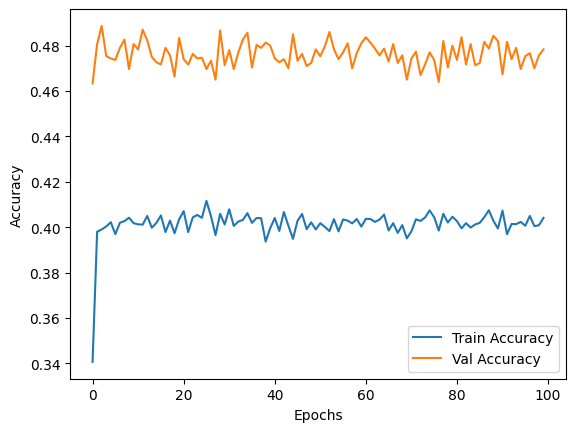

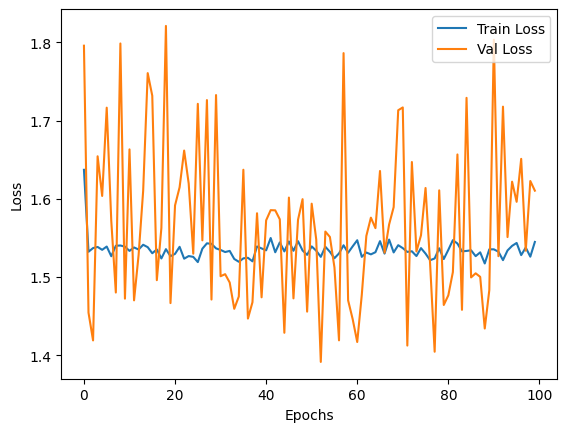

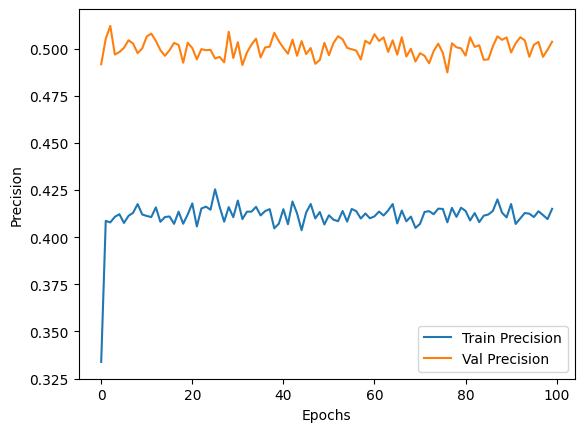

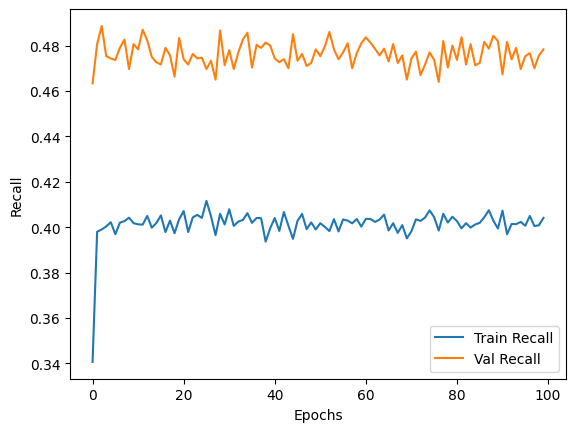

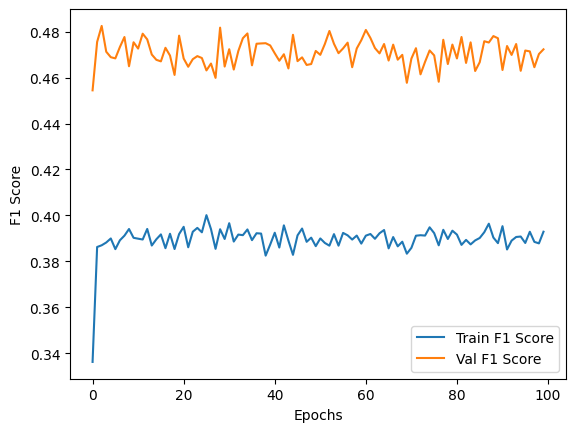

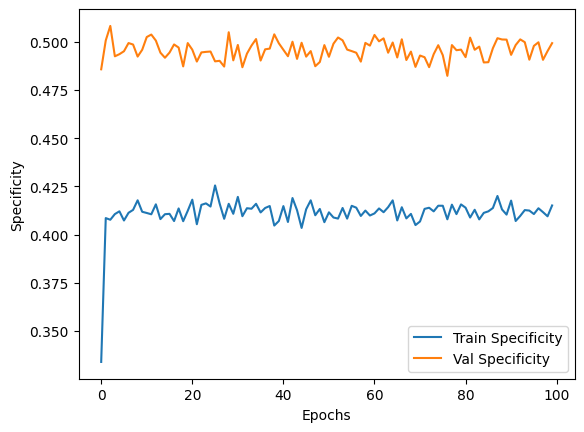

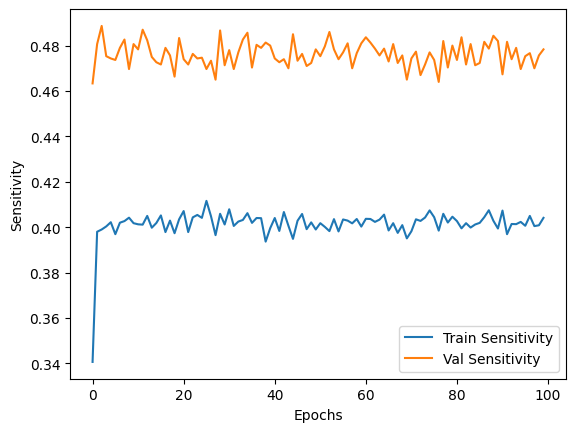

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device configuration (using both GPUs if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Define data augmentation and transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=1.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_train/seg_train/', transform=train_transforms)
test_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_test/seg_test/', transform=test_transforms)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load a pre-trained DenseNet model
model = models.densenet169(weights=None)
model.classifier = nn.Linear(model.classifier.in_features, 6)  # Modify the output for 6 classes
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

# Gradient scaler for mixed precision
scaler = GradScaler()

# Initialize lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []
train_specificities, val_specificities = [], []
train_sensitivities, val_sensitivities = [], []

# Function to calculate specificity
def calculate_specificity(cm):
    tn = np.diag(cm)
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / (tn + fp + 1e-10)
    return np.mean(specificity)

# Function to train the model with mixed precision
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=80):
    model.train()
    accumulation_steps = 2  
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        scheduler.step(running_loss)

        cm = confusion_matrix(all_labels, all_preds)
        specificity = calculate_specificity(cm)
        sensitivity = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)
        train_f1_scores.append(epoch_f1)
        train_specificities.append(specificity)
        train_sensitivities.append(sensitivity)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, '
              f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}, '
              f'Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}')

        torch.cuda.empty_cache()


def validate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    specificity = calculate_specificity(cm)
    sensitivity = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    val_specificities.append(specificity)
    val_sensitivities.append(sensitivity)

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, '
          f'Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}')
    return val_acc

# Function to save the model checkpoints
def save_checkpoint(state, filename="checkpoint_densenet.pth"):
    torch.save(state, filename)

# Start training
num_epochs = 100
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=1)
    val_acc = validate_model(model, test_loader, criterion)

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }, filename=f"model_epoch_{epoch+1}.pth")

# Save the best model after training completion
final_model_path = "/kaggle/working/best_model_densenet.pth"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_accuracy': best_acc,
}, final_model_path)

print(f"Best model saved with accuracy: {best_acc:.4f} at {final_model_path}")

# Plot the training and validation metrics over time
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.plot(train_metrics, label=f'Train {metric_name}')
    plt.plot(val_metrics, label=f'Val {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

plot_metrics(train_accuracies, val_accuracies, "Accuracy")
plot_metrics(train_losses, val_losses, "Loss")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_f1_scores, val_f1_scores, "F1 Score")
plot_metrics(train_specificities, val_specificities, "Specificity")
plot_metrics(train_sensitivities, val_sensitivities, "Sensitivity")


/tmp/ipykernel_30/1592984403.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 2.9061, Accuracy: 0.2092, Precision: 0.2073, Recall: 0.2092, F1 Score: 0.2023, Specificity: 0.2074, Sensitivity: 0.2092


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.7877, Accuracy: 0.2493, Precision: 0.5614, Recall: 0.2493, F1 Score: 0.1749, Specificity: 0.2423, Sensitivity: 0.2493
Epoch 2/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.6500, Accuracy: 0.3040, Precision: 0.2784, Recall: 0.3040, F1 Score: 0.2755, Specificity: 0.2780, Sensitivity: 0.3040


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.5405, Accuracy: 0.3783, Precision: 0.4667, Recall: 0.3783, F1 Score: 0.2907, Specificity: 0.2937, Sensitivity: 0.3783
Epoch 3/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.5224, Accuracy: 0.3611, Precision: 0.3326, Recall: 0.3611, F1 Score: 0.3341, Specificity: 0.3322, Sensitivity: 0.3611


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3729, Accuracy: 0.4050, Precision: 0.4398, Recall: 0.4050, F1 Score: 0.3391, Specificity: 0.4393, Sensitivity: 0.4050
Epoch 4/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.4579, Accuracy: 0.3892, Precision: 0.3575, Recall: 0.3892, F1 Score: 0.3566, Specificity: 0.3570, Sensitivity: 0.3892


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.8416, Accuracy: 0.4630, Precision: 0.4406, Recall: 0.4630, F1 Score: 0.4198, Specificity: 0.4382, Sensitivity: 0.4630
Epoch 5/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.4104, Accuracy: 0.4106, Precision: 0.3959, Recall: 0.4106, F1 Score: 0.3926, Specificity: 0.3958, Sensitivity: 0.4106


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3345, Accuracy: 0.5020, Precision: 0.5235, Recall: 0.5020, F1 Score: 0.4549, Specificity: 0.5231, Sensitivity: 0.5020
Epoch 6/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3833, Accuracy: 0.4218, Precision: 0.4033, Recall: 0.4218, F1 Score: 0.4005, Specificity: 0.4029, Sensitivity: 0.4218


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2351, Accuracy: 0.5453, Precision: 0.5316, Recall: 0.5453, F1 Score: 0.5245, Specificity: 0.5308, Sensitivity: 0.5453
Epoch 7/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3639, Accuracy: 0.4401, Precision: 0.4222, Recall: 0.4401, F1 Score: 0.4170, Specificity: 0.4221, Sensitivity: 0.4401


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.5402, Accuracy: 0.5137, Precision: 0.5511, Recall: 0.5137, F1 Score: 0.5056, Specificity: 0.5487, Sensitivity: 0.5137
Epoch 8/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3503, Accuracy: 0.4424, Precision: 0.4248, Recall: 0.4424, F1 Score: 0.4248, Specificity: 0.4248, Sensitivity: 0.4424


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2753, Accuracy: 0.5553, Precision: 0.5311, Recall: 0.5553, F1 Score: 0.5104, Specificity: 0.5303, Sensitivity: 0.5553
Epoch 9/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3268, Accuracy: 0.4562, Precision: 0.4341, Recall: 0.4562, F1 Score: 0.4327, Specificity: 0.4332, Sensitivity: 0.4562


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2389, Accuracy: 0.5503, Precision: 0.6412, Recall: 0.5503, F1 Score: 0.4929, Specificity: 0.4887, Sensitivity: 0.5503
Epoch 10/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2980, Accuracy: 0.4700, Precision: 0.4524, Recall: 0.4700, F1 Score: 0.4497, Specificity: 0.4522, Sensitivity: 0.4700


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.9424, Accuracy: 0.5657, Precision: 0.5710, Recall: 0.5657, F1 Score: 0.5561, Specificity: 0.5704, Sensitivity: 0.5657
Epoch 11/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2846, Accuracy: 0.4740, Precision: 0.4554, Recall: 0.4740, F1 Score: 0.4566, Specificity: 0.4550, Sensitivity: 0.4740


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 2.2199, Accuracy: 0.5717, Precision: 0.5764, Recall: 0.5717, F1 Score: 0.5651, Specificity: 0.5779, Sensitivity: 0.5717
Epoch 12/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2732, Accuracy: 0.4848, Precision: 0.4689, Recall: 0.4848, F1 Score: 0.4664, Specificity: 0.4692, Sensitivity: 0.4848


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3130, Accuracy: 0.5840, Precision: 0.5873, Recall: 0.5840, F1 Score: 0.5739, Specificity: 0.5850, Sensitivity: 0.5840
Epoch 13/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2494, Accuracy: 0.4943, Precision: 0.4787, Recall: 0.4943, F1 Score: 0.4794, Specificity: 0.4785, Sensitivity: 0.4943


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2930, Accuracy: 0.5937, Precision: 0.5977, Recall: 0.5937, F1 Score: 0.5571, Specificity: 0.6013, Sensitivity: 0.5937
Epoch 14/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2561, Accuracy: 0.4937, Precision: 0.4810, Recall: 0.4937, F1 Score: 0.4799, Specificity: 0.4812, Sensitivity: 0.4937


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.6272, Accuracy: 0.5830, Precision: 0.5931, Recall: 0.5830, F1 Score: 0.5568, Specificity: 0.5953, Sensitivity: 0.5830
Epoch 15/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2366, Accuracy: 0.5018, Precision: 0.4884, Recall: 0.5018, F1 Score: 0.4875, Specificity: 0.4887, Sensitivity: 0.5018


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4716, Accuracy: 0.6003, Precision: 0.6074, Recall: 0.6003, F1 Score: 0.5894, Specificity: 0.6063, Sensitivity: 0.6003
Epoch 16/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2278, Accuracy: 0.5105, Precision: 0.4998, Recall: 0.5105, F1 Score: 0.4963, Specificity: 0.5002, Sensitivity: 0.5105


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4417, Accuracy: 0.6140, Precision: 0.6180, Recall: 0.6140, F1 Score: 0.6007, Specificity: 0.6187, Sensitivity: 0.6140
Epoch 17/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2072, Accuracy: 0.5223, Precision: 0.5084, Recall: 0.5223, F1 Score: 0.5089, Specificity: 0.5085, Sensitivity: 0.5223


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.6356, Accuracy: 0.6037, Precision: 0.5982, Recall: 0.6037, F1 Score: 0.5927, Specificity: 0.5989, Sensitivity: 0.6037
Epoch 18/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1992, Accuracy: 0.5202, Precision: 0.5114, Recall: 0.5202, F1 Score: 0.5111, Specificity: 0.5118, Sensitivity: 0.5202


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0015, Accuracy: 0.6203, Precision: 0.6266, Recall: 0.6203, F1 Score: 0.6088, Specificity: 0.6262, Sensitivity: 0.6203
Epoch 19/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1874, Accuracy: 0.5324, Precision: 0.5225, Recall: 0.5324, F1 Score: 0.5220, Specificity: 0.5231, Sensitivity: 0.5324


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9879, Accuracy: 0.6240, Precision: 0.6216, Recall: 0.6240, F1 Score: 0.6083, Specificity: 0.6231, Sensitivity: 0.6240
Epoch 20/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1840, Accuracy: 0.5333, Precision: 0.5226, Recall: 0.5333, F1 Score: 0.5213, Specificity: 0.5226, Sensitivity: 0.5333


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9758, Accuracy: 0.6373, Precision: 0.6385, Recall: 0.6373, F1 Score: 0.6344, Specificity: 0.6370, Sensitivity: 0.6373
Epoch 21/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1729, Accuracy: 0.5366, Precision: 0.5264, Recall: 0.5366, F1 Score: 0.5238, Specificity: 0.5268, Sensitivity: 0.5366


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9460, Accuracy: 0.6353, Precision: 0.6522, Recall: 0.6353, F1 Score: 0.6242, Specificity: 0.6516, Sensitivity: 0.6353
Epoch 22/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1600, Accuracy: 0.5428, Precision: 0.5348, Recall: 0.5428, F1 Score: 0.5334, Specificity: 0.5353, Sensitivity: 0.5428


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9201, Accuracy: 0.6547, Precision: 0.6586, Recall: 0.6547, F1 Score: 0.6504, Specificity: 0.6570, Sensitivity: 0.6547
Epoch 23/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1455, Accuracy: 0.5505, Precision: 0.5412, Recall: 0.5505, F1 Score: 0.5398, Specificity: 0.5418, Sensitivity: 0.5505


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9453, Accuracy: 0.6463, Precision: 0.6523, Recall: 0.6463, F1 Score: 0.6421, Specificity: 0.6502, Sensitivity: 0.6463
Epoch 24/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1429, Accuracy: 0.5521, Precision: 0.5424, Recall: 0.5521, F1 Score: 0.5434, Specificity: 0.5427, Sensitivity: 0.5521


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2047, Accuracy: 0.6223, Precision: 0.6230, Recall: 0.6223, F1 Score: 0.6034, Specificity: 0.6244, Sensitivity: 0.6223
Epoch 25/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1282, Accuracy: 0.5635, Precision: 0.5572, Recall: 0.5635, F1 Score: 0.5568, Specificity: 0.5577, Sensitivity: 0.5635


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9305, Accuracy: 0.6483, Precision: 0.6580, Recall: 0.6483, F1 Score: 0.6468, Specificity: 0.6565, Sensitivity: 0.6483
Epoch 26/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1329, Accuracy: 0.5598, Precision: 0.5529, Recall: 0.5598, F1 Score: 0.5519, Specificity: 0.5537, Sensitivity: 0.5598


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.7478, Accuracy: 0.6400, Precision: 0.6497, Recall: 0.6400, F1 Score: 0.6335, Specificity: 0.6509, Sensitivity: 0.6400
Epoch 27/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1112, Accuracy: 0.5658, Precision: 0.5616, Recall: 0.5658, F1 Score: 0.5597, Specificity: 0.5626, Sensitivity: 0.5658


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3650, Accuracy: 0.6297, Precision: 0.6359, Recall: 0.6297, F1 Score: 0.6257, Specificity: 0.6367, Sensitivity: 0.6297
Epoch 28/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1200, Accuracy: 0.5607, Precision: 0.5546, Recall: 0.5607, F1 Score: 0.5557, Specificity: 0.5550, Sensitivity: 0.5607


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0706, Accuracy: 0.6553, Precision: 0.6571, Recall: 0.6553, F1 Score: 0.6447, Specificity: 0.6574, Sensitivity: 0.6553
Epoch 29/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1018, Accuracy: 0.5731, Precision: 0.5660, Recall: 0.5731, F1 Score: 0.5635, Specificity: 0.5669, Sensitivity: 0.5731


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1026, Accuracy: 0.6330, Precision: 0.6371, Recall: 0.6330, F1 Score: 0.6267, Specificity: 0.6380, Sensitivity: 0.6330
Epoch 30/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0856, Accuracy: 0.5813, Precision: 0.5747, Recall: 0.5813, F1 Score: 0.5743, Specificity: 0.5753, Sensitivity: 0.5813


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9152, Accuracy: 0.6610, Precision: 0.6666, Recall: 0.6610, F1 Score: 0.6536, Specificity: 0.6668, Sensitivity: 0.6610
Epoch 31/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0944, Accuracy: 0.5730, Precision: 0.5664, Recall: 0.5730, F1 Score: 0.5651, Specificity: 0.5672, Sensitivity: 0.5730


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2190, Accuracy: 0.6693, Precision: 0.6678, Recall: 0.6693, F1 Score: 0.6663, Specificity: 0.6696, Sensitivity: 0.6693
Epoch 32/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0797, Accuracy: 0.5856, Precision: 0.5797, Recall: 0.5856, F1 Score: 0.5796, Specificity: 0.5802, Sensitivity: 0.5856


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2197, Accuracy: 0.6557, Precision: 0.6691, Recall: 0.6557, F1 Score: 0.6539, Specificity: 0.6660, Sensitivity: 0.6557
Epoch 33/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0736, Accuracy: 0.5829, Precision: 0.5759, Recall: 0.5829, F1 Score: 0.5750, Specificity: 0.5767, Sensitivity: 0.5829


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0785, Accuracy: 0.6550, Precision: 0.6675, Recall: 0.6550, F1 Score: 0.6498, Specificity: 0.6642, Sensitivity: 0.6550
Epoch 34/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0761, Accuracy: 0.5858, Precision: 0.5801, Recall: 0.5858, F1 Score: 0.5803, Specificity: 0.5808, Sensitivity: 0.5858


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9522, Accuracy: 0.6733, Precision: 0.6723, Recall: 0.6733, F1 Score: 0.6653, Specificity: 0.6729, Sensitivity: 0.6733
Epoch 35/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0656, Accuracy: 0.5879, Precision: 0.5821, Recall: 0.5879, F1 Score: 0.5822, Specificity: 0.5824, Sensitivity: 0.5879


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2769, Accuracy: 0.6550, Precision: 0.6595, Recall: 0.6550, F1 Score: 0.6490, Specificity: 0.6587, Sensitivity: 0.6550
Epoch 36/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0613, Accuracy: 0.5921, Precision: 0.5846, Recall: 0.5921, F1 Score: 0.5857, Specificity: 0.5848, Sensitivity: 0.5921


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0933, Accuracy: 0.6857, Precision: 0.6824, Recall: 0.6857, F1 Score: 0.6805, Specificity: 0.6826, Sensitivity: 0.6857
Epoch 37/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0583, Accuracy: 0.5879, Precision: 0.5808, Recall: 0.5879, F1 Score: 0.5824, Specificity: 0.5809, Sensitivity: 0.5879


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0665, Accuracy: 0.6637, Precision: 0.6686, Recall: 0.6637, F1 Score: 0.6525, Specificity: 0.6702, Sensitivity: 0.6637
Epoch 38/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0525, Accuracy: 0.5902, Precision: 0.5832, Recall: 0.5902, F1 Score: 0.5843, Specificity: 0.5834, Sensitivity: 0.5902


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2730, Accuracy: 0.6710, Precision: 0.6682, Recall: 0.6710, F1 Score: 0.6666, Specificity: 0.6691, Sensitivity: 0.6710
Epoch 39/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0449, Accuracy: 0.5979, Precision: 0.5928, Recall: 0.5979, F1 Score: 0.5933, Specificity: 0.5932, Sensitivity: 0.5979


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4225, Accuracy: 0.6763, Precision: 0.6773, Recall: 0.6763, F1 Score: 0.6746, Specificity: 0.6792, Sensitivity: 0.6763
Epoch 40/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0332, Accuracy: 0.6072, Precision: 0.6014, Recall: 0.6072, F1 Score: 0.6020, Specificity: 0.6018, Sensitivity: 0.6072


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1949, Accuracy: 0.6830, Precision: 0.6898, Recall: 0.6830, F1 Score: 0.6787, Specificity: 0.6905, Sensitivity: 0.6830
Epoch 41/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0372, Accuracy: 0.6028, Precision: 0.5962, Recall: 0.6028, F1 Score: 0.5972, Specificity: 0.5966, Sensitivity: 0.6028


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.8571, Accuracy: 0.6567, Precision: 0.6713, Recall: 0.6567, F1 Score: 0.6476, Specificity: 0.6699, Sensitivity: 0.6567
Epoch 42/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0323, Accuracy: 0.6008, Precision: 0.5950, Recall: 0.6008, F1 Score: 0.5945, Specificity: 0.5959, Sensitivity: 0.6008


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2157, Accuracy: 0.6713, Precision: 0.6770, Recall: 0.6713, F1 Score: 0.6661, Specificity: 0.6761, Sensitivity: 0.6713
Epoch 43/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0280, Accuracy: 0.6080, Precision: 0.6035, Recall: 0.6080, F1 Score: 0.6032, Specificity: 0.6041, Sensitivity: 0.6080


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0395, Accuracy: 0.6907, Precision: 0.6945, Recall: 0.6907, F1 Score: 0.6891, Specificity: 0.6931, Sensitivity: 0.6907
Epoch 44/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0231, Accuracy: 0.6108, Precision: 0.6063, Recall: 0.6108, F1 Score: 0.6067, Specificity: 0.6069, Sensitivity: 0.6108


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2783, Accuracy: 0.6930, Precision: 0.6995, Recall: 0.6930, F1 Score: 0.6924, Specificity: 0.6984, Sensitivity: 0.6930
Epoch 45/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0144, Accuracy: 0.6078, Precision: 0.6027, Recall: 0.6078, F1 Score: 0.6033, Specificity: 0.6035, Sensitivity: 0.6078


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2206, Accuracy: 0.6870, Precision: 0.6885, Recall: 0.6870, F1 Score: 0.6797, Specificity: 0.6921, Sensitivity: 0.6870
Epoch 46/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0166, Accuracy: 0.6164, Precision: 0.6107, Recall: 0.6164, F1 Score: 0.6111, Specificity: 0.6111, Sensitivity: 0.6164


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4318, Accuracy: 0.6887, Precision: 0.6858, Recall: 0.6887, F1 Score: 0.6849, Specificity: 0.6856, Sensitivity: 0.6887
Epoch 47/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0057, Accuracy: 0.6132, Precision: 0.6088, Recall: 0.6132, F1 Score: 0.6092, Specificity: 0.6093, Sensitivity: 0.6132


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1193, Accuracy: 0.6957, Precision: 0.7001, Recall: 0.6957, F1 Score: 0.6924, Specificity: 0.7013, Sensitivity: 0.6957
Epoch 48/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0016, Accuracy: 0.6114, Precision: 0.6066, Recall: 0.6114, F1 Score: 0.6073, Specificity: 0.6071, Sensitivity: 0.6114


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0207, Accuracy: 0.6827, Precision: 0.6896, Recall: 0.6827, F1 Score: 0.6770, Specificity: 0.6897, Sensitivity: 0.6827
Epoch 49/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0089, Accuracy: 0.6136, Precision: 0.6081, Recall: 0.6136, F1 Score: 0.6086, Specificity: 0.6086, Sensitivity: 0.6136


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8162, Accuracy: 0.7100, Precision: 0.7076, Recall: 0.7100, F1 Score: 0.7077, Specificity: 0.7093, Sensitivity: 0.7100
Epoch 50/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0074, Accuracy: 0.6142, Precision: 0.6099, Recall: 0.6142, F1 Score: 0.6108, Specificity: 0.6103, Sensitivity: 0.6142


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8909, Accuracy: 0.7033, Precision: 0.7071, Recall: 0.7033, F1 Score: 0.7021, Specificity: 0.7066, Sensitivity: 0.7033
Epoch 51/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9976, Accuracy: 0.6148, Precision: 0.6111, Recall: 0.6148, F1 Score: 0.6105, Specificity: 0.6121, Sensitivity: 0.6148


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7863, Accuracy: 0.7017, Precision: 0.7021, Recall: 0.7017, F1 Score: 0.6985, Specificity: 0.7027, Sensitivity: 0.7017
Epoch 52/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9964, Accuracy: 0.6213, Precision: 0.6164, Recall: 0.6213, F1 Score: 0.6164, Specificity: 0.6171, Sensitivity: 0.6213


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7941, Accuracy: 0.7087, Precision: 0.7074, Recall: 0.7087, F1 Score: 0.7051, Specificity: 0.7088, Sensitivity: 0.7087
Epoch 53/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9830, Accuracy: 0.6251, Precision: 0.6192, Recall: 0.6251, F1 Score: 0.6201, Specificity: 0.6195, Sensitivity: 0.6251


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8174, Accuracy: 0.7153, Precision: 0.7161, Recall: 0.7153, F1 Score: 0.7123, Specificity: 0.7181, Sensitivity: 0.7153
Epoch 54/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9922, Accuracy: 0.6215, Precision: 0.6160, Recall: 0.6215, F1 Score: 0.6168, Specificity: 0.6162, Sensitivity: 0.6215


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0778, Accuracy: 0.6967, Precision: 0.6994, Recall: 0.6967, F1 Score: 0.6960, Specificity: 0.6988, Sensitivity: 0.6967
Epoch 55/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9896, Accuracy: 0.6211, Precision: 0.6160, Recall: 0.6211, F1 Score: 0.6163, Specificity: 0.6164, Sensitivity: 0.6211


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8992, Accuracy: 0.7090, Precision: 0.7136, Recall: 0.7090, F1 Score: 0.7091, Specificity: 0.7138, Sensitivity: 0.7090
Epoch 56/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9838, Accuracy: 0.6216, Precision: 0.6164, Recall: 0.6216, F1 Score: 0.6165, Specificity: 0.6169, Sensitivity: 0.6216


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8466, Accuracy: 0.7040, Precision: 0.7029, Recall: 0.7040, F1 Score: 0.7006, Specificity: 0.7047, Sensitivity: 0.7040
Epoch 57/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9817, Accuracy: 0.6270, Precision: 0.6215, Recall: 0.6270, F1 Score: 0.6215, Specificity: 0.6219, Sensitivity: 0.6270


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0351, Accuracy: 0.7120, Precision: 0.7121, Recall: 0.7120, F1 Score: 0.7108, Specificity: 0.7120, Sensitivity: 0.7120
Epoch 58/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9799, Accuracy: 0.6263, Precision: 0.6224, Recall: 0.6263, F1 Score: 0.6227, Specificity: 0.6229, Sensitivity: 0.6263


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0560, Accuracy: 0.7030, Precision: 0.7029, Recall: 0.7030, F1 Score: 0.6995, Specificity: 0.7046, Sensitivity: 0.7030
Epoch 59/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9824, Accuracy: 0.6250, Precision: 0.6202, Recall: 0.6250, F1 Score: 0.6208, Specificity: 0.6206, Sensitivity: 0.6250


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9516, Accuracy: 0.7117, Precision: 0.7098, Recall: 0.7117, F1 Score: 0.7089, Specificity: 0.7117, Sensitivity: 0.7117
Epoch 60/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9772, Accuracy: 0.6292, Precision: 0.6244, Recall: 0.6292, F1 Score: 0.6246, Specificity: 0.6249, Sensitivity: 0.6292


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3869, Accuracy: 0.6950, Precision: 0.6975, Recall: 0.6950, F1 Score: 0.6910, Specificity: 0.7009, Sensitivity: 0.6950
Epoch 61/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9768, Accuracy: 0.6282, Precision: 0.6235, Recall: 0.6282, F1 Score: 0.6245, Specificity: 0.6240, Sensitivity: 0.6282


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2075, Accuracy: 0.7067, Precision: 0.7041, Recall: 0.7067, F1 Score: 0.7028, Specificity: 0.7064, Sensitivity: 0.7067
Epoch 62/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9694, Accuracy: 0.6320, Precision: 0.6264, Recall: 0.6320, F1 Score: 0.6270, Specificity: 0.6268, Sensitivity: 0.6320


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8923, Accuracy: 0.7037, Precision: 0.7063, Recall: 0.7037, F1 Score: 0.6988, Specificity: 0.7090, Sensitivity: 0.7037
Epoch 63/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9600, Accuracy: 0.6326, Precision: 0.6284, Recall: 0.6326, F1 Score: 0.6285, Specificity: 0.6290, Sensitivity: 0.6326


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9227, Accuracy: 0.7073, Precision: 0.7060, Recall: 0.7073, F1 Score: 0.7042, Specificity: 0.7070, Sensitivity: 0.7073
Epoch 64/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9721, Accuracy: 0.6314, Precision: 0.6265, Recall: 0.6314, F1 Score: 0.6277, Specificity: 0.6267, Sensitivity: 0.6314


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0714, Accuracy: 0.6953, Precision: 0.6957, Recall: 0.6953, F1 Score: 0.6912, Specificity: 0.6980, Sensitivity: 0.6953
Epoch 65/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9628, Accuracy: 0.6377, Precision: 0.6332, Recall: 0.6377, F1 Score: 0.6333, Specificity: 0.6337, Sensitivity: 0.6377


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1505, Accuracy: 0.6990, Precision: 0.6982, Recall: 0.6990, F1 Score: 0.6964, Specificity: 0.6991, Sensitivity: 0.6990
Epoch 66/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9668, Accuracy: 0.6347, Precision: 0.6295, Recall: 0.6347, F1 Score: 0.6308, Specificity: 0.6299, Sensitivity: 0.6347


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4966, Accuracy: 0.6907, Precision: 0.6930, Recall: 0.6907, F1 Score: 0.6888, Specificity: 0.6941, Sensitivity: 0.6907
Epoch 67/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9572, Accuracy: 0.6327, Precision: 0.6283, Recall: 0.6327, F1 Score: 0.6291, Specificity: 0.6288, Sensitivity: 0.6327


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2512, Accuracy: 0.6957, Precision: 0.6988, Recall: 0.6957, F1 Score: 0.6924, Specificity: 0.7000, Sensitivity: 0.6957
Epoch 68/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9590, Accuracy: 0.6372, Precision: 0.6332, Recall: 0.6372, F1 Score: 0.6331, Specificity: 0.6337, Sensitivity: 0.6372


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9920, Accuracy: 0.6977, Precision: 0.7027, Recall: 0.6977, F1 Score: 0.6939, Specificity: 0.7019, Sensitivity: 0.6977
Epoch 69/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9595, Accuracy: 0.6327, Precision: 0.6282, Recall: 0.6327, F1 Score: 0.6282, Specificity: 0.6287, Sensitivity: 0.6327


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2242, Accuracy: 0.7063, Precision: 0.7060, Recall: 0.7063, F1 Score: 0.7028, Specificity: 0.7066, Sensitivity: 0.7063
Epoch 70/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9530, Accuracy: 0.6358, Precision: 0.6312, Recall: 0.6358, F1 Score: 0.6321, Specificity: 0.6315, Sensitivity: 0.6358


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9173, Accuracy: 0.7133, Precision: 0.7137, Recall: 0.7133, F1 Score: 0.7101, Specificity: 0.7135, Sensitivity: 0.7133
Epoch 71/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9612, Accuracy: 0.6379, Precision: 0.6336, Recall: 0.6379, F1 Score: 0.6343, Specificity: 0.6340, Sensitivity: 0.6379


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4216, Accuracy: 0.7033, Precision: 0.7020, Recall: 0.7033, F1 Score: 0.7003, Specificity: 0.7044, Sensitivity: 0.7033
Epoch 72/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9534, Accuracy: 0.6417, Precision: 0.6371, Recall: 0.6417, F1 Score: 0.6385, Specificity: 0.6374, Sensitivity: 0.6417


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0258, Accuracy: 0.7080, Precision: 0.7071, Recall: 0.7080, F1 Score: 0.7045, Specificity: 0.7088, Sensitivity: 0.7080
Epoch 73/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9545, Accuracy: 0.6375, Precision: 0.6334, Recall: 0.6375, F1 Score: 0.6336, Specificity: 0.6339, Sensitivity: 0.6375


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9175, Accuracy: 0.7123, Precision: 0.7115, Recall: 0.7123, F1 Score: 0.7084, Specificity: 0.7116, Sensitivity: 0.7123
Epoch 74/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9552, Accuracy: 0.6362, Precision: 0.6321, Recall: 0.6362, F1 Score: 0.6327, Specificity: 0.6325, Sensitivity: 0.6362


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2848, Accuracy: 0.7033, Precision: 0.7032, Recall: 0.7033, F1 Score: 0.7011, Specificity: 0.7041, Sensitivity: 0.7033
Epoch 75/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9449, Accuracy: 0.6420, Precision: 0.6379, Recall: 0.6420, F1 Score: 0.6386, Specificity: 0.6385, Sensitivity: 0.6420


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2832, Accuracy: 0.7090, Precision: 0.7087, Recall: 0.7090, F1 Score: 0.7059, Specificity: 0.7092, Sensitivity: 0.7090
Epoch 76/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9482, Accuracy: 0.6435, Precision: 0.6387, Recall: 0.6435, F1 Score: 0.6395, Specificity: 0.6391, Sensitivity: 0.6435


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0207, Accuracy: 0.7103, Precision: 0.7113, Recall: 0.7103, F1 Score: 0.7088, Specificity: 0.7119, Sensitivity: 0.7103
Epoch 77/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9551, Accuracy: 0.6394, Precision: 0.6351, Recall: 0.6394, F1 Score: 0.6357, Specificity: 0.6354, Sensitivity: 0.6394


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0425, Accuracy: 0.7150, Precision: 0.7127, Recall: 0.7150, F1 Score: 0.7122, Specificity: 0.7142, Sensitivity: 0.7150
Epoch 78/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9504, Accuracy: 0.6404, Precision: 0.6355, Recall: 0.6404, F1 Score: 0.6363, Specificity: 0.6358, Sensitivity: 0.6404


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7959, Accuracy: 0.7117, Precision: 0.7110, Recall: 0.7117, F1 Score: 0.7084, Specificity: 0.7124, Sensitivity: 0.7117
Epoch 79/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9389, Accuracy: 0.6423, Precision: 0.6377, Recall: 0.6423, F1 Score: 0.6384, Specificity: 0.6382, Sensitivity: 0.6423


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2703, Accuracy: 0.7157, Precision: 0.7141, Recall: 0.7157, F1 Score: 0.7131, Specificity: 0.7149, Sensitivity: 0.7157
Epoch 80/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9417, Accuracy: 0.6459, Precision: 0.6414, Recall: 0.6459, F1 Score: 0.6418, Specificity: 0.6419, Sensitivity: 0.6459


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9165, Accuracy: 0.7137, Precision: 0.7123, Recall: 0.7137, F1 Score: 0.7108, Specificity: 0.7138, Sensitivity: 0.7137
Epoch 81/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9419, Accuracy: 0.6394, Precision: 0.6346, Recall: 0.6394, F1 Score: 0.6357, Specificity: 0.6348, Sensitivity: 0.6394


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1417, Accuracy: 0.6973, Precision: 0.7017, Recall: 0.6973, F1 Score: 0.6930, Specificity: 0.7043, Sensitivity: 0.6973
Epoch 82/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9447, Accuracy: 0.6432, Precision: 0.6388, Recall: 0.6432, F1 Score: 0.6390, Specificity: 0.6395, Sensitivity: 0.6432


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1152, Accuracy: 0.7087, Precision: 0.7148, Recall: 0.7087, F1 Score: 0.7059, Specificity: 0.7160, Sensitivity: 0.7087
Epoch 83/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9450, Accuracy: 0.6441, Precision: 0.6396, Recall: 0.6441, F1 Score: 0.6406, Specificity: 0.6398, Sensitivity: 0.6441


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9567, Accuracy: 0.7150, Precision: 0.7144, Recall: 0.7150, F1 Score: 0.7109, Specificity: 0.7157, Sensitivity: 0.7150
Epoch 84/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9504, Accuracy: 0.6392, Precision: 0.6345, Recall: 0.6392, F1 Score: 0.6350, Specificity: 0.6350, Sensitivity: 0.6392


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4557, Accuracy: 0.7073, Precision: 0.7091, Recall: 0.7073, F1 Score: 0.7055, Specificity: 0.7088, Sensitivity: 0.7073
Epoch 85/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9316, Accuracy: 0.6466, Precision: 0.6433, Recall: 0.6466, F1 Score: 0.6434, Specificity: 0.6440, Sensitivity: 0.6466


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0474, Accuracy: 0.7180, Precision: 0.7175, Recall: 0.7180, F1 Score: 0.7160, Specificity: 0.7182, Sensitivity: 0.7180
Epoch 86/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9382, Accuracy: 0.6420, Precision: 0.6379, Recall: 0.6420, F1 Score: 0.6388, Specificity: 0.6384, Sensitivity: 0.6420


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8843, Accuracy: 0.7187, Precision: 0.7185, Recall: 0.7187, F1 Score: 0.7164, Specificity: 0.7194, Sensitivity: 0.7187
Epoch 87/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9353, Accuracy: 0.6458, Precision: 0.6424, Recall: 0.6458, F1 Score: 0.6419, Specificity: 0.6430, Sensitivity: 0.6458


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1122, Accuracy: 0.7127, Precision: 0.7127, Recall: 0.7127, F1 Score: 0.7102, Specificity: 0.7140, Sensitivity: 0.7127
Epoch 88/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9250, Accuracy: 0.6479, Precision: 0.6433, Recall: 0.6479, F1 Score: 0.6444, Specificity: 0.6434, Sensitivity: 0.6479


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9689, Accuracy: 0.7177, Precision: 0.7209, Recall: 0.7177, F1 Score: 0.7166, Specificity: 0.7220, Sensitivity: 0.7177
Epoch 89/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9467, Accuracy: 0.6389, Precision: 0.6341, Recall: 0.6389, F1 Score: 0.6353, Specificity: 0.6344, Sensitivity: 0.6389


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9227, Accuracy: 0.7097, Precision: 0.7130, Recall: 0.7097, F1 Score: 0.7060, Specificity: 0.7133, Sensitivity: 0.7097
Epoch 90/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9438, Accuracy: 0.6392, Precision: 0.6351, Recall: 0.6392, F1 Score: 0.6355, Specificity: 0.6357, Sensitivity: 0.6392


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8833, Accuracy: 0.7173, Precision: 0.7200, Recall: 0.7173, F1 Score: 0.7164, Specificity: 0.7208, Sensitivity: 0.7173
Epoch 91/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9349, Accuracy: 0.6509, Precision: 0.6467, Recall: 0.6509, F1 Score: 0.6474, Specificity: 0.6471, Sensitivity: 0.6509


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9016, Accuracy: 0.7157, Precision: 0.7170, Recall: 0.7157, F1 Score: 0.7131, Specificity: 0.7183, Sensitivity: 0.7157
Epoch 92/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9326, Accuracy: 0.6458, Precision: 0.6413, Recall: 0.6458, F1 Score: 0.6423, Specificity: 0.6416, Sensitivity: 0.6458


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2351, Accuracy: 0.7150, Precision: 0.7162, Recall: 0.7150, F1 Score: 0.7129, Specificity: 0.7165, Sensitivity: 0.7150
Epoch 93/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9374, Accuracy: 0.6453, Precision: 0.6409, Recall: 0.6453, F1 Score: 0.6414, Specificity: 0.6415, Sensitivity: 0.6453


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8664, Accuracy: 0.7163, Precision: 0.7173, Recall: 0.7163, F1 Score: 0.7129, Specificity: 0.7190, Sensitivity: 0.7163
Epoch 94/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9390, Accuracy: 0.6408, Precision: 0.6362, Recall: 0.6408, F1 Score: 0.6366, Specificity: 0.6368, Sensitivity: 0.6408


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0263, Accuracy: 0.7117, Precision: 0.7120, Recall: 0.7117, F1 Score: 0.7075, Specificity: 0.7142, Sensitivity: 0.7117
Epoch 95/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9338, Accuracy: 0.6459, Precision: 0.6413, Recall: 0.6459, F1 Score: 0.6422, Specificity: 0.6417, Sensitivity: 0.6459


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8653, Accuracy: 0.7180, Precision: 0.7161, Recall: 0.7180, F1 Score: 0.7145, Specificity: 0.7173, Sensitivity: 0.7180
Epoch 96/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9251, Accuracy: 0.6459, Precision: 0.6409, Recall: 0.6459, F1 Score: 0.6422, Specificity: 0.6411, Sensitivity: 0.6459


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8948, Accuracy: 0.7173, Precision: 0.7164, Recall: 0.7173, F1 Score: 0.7134, Specificity: 0.7184, Sensitivity: 0.7173
Epoch 97/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9282, Accuracy: 0.6452, Precision: 0.6406, Recall: 0.6452, F1 Score: 0.6410, Specificity: 0.6411, Sensitivity: 0.6452


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9360, Accuracy: 0.7173, Precision: 0.7185, Recall: 0.7173, F1 Score: 0.7145, Specificity: 0.7204, Sensitivity: 0.7173
Epoch 98/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9342, Accuracy: 0.6432, Precision: 0.6390, Recall: 0.6432, F1 Score: 0.6399, Specificity: 0.6394, Sensitivity: 0.6432


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9091, Accuracy: 0.7127, Precision: 0.7126, Recall: 0.7127, F1 Score: 0.7100, Specificity: 0.7148, Sensitivity: 0.7127
Epoch 99/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9362, Accuracy: 0.6383, Precision: 0.6344, Recall: 0.6383, F1 Score: 0.6352, Specificity: 0.6348, Sensitivity: 0.6383


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.2853, Accuracy: 0.7120, Precision: 0.7112, Recall: 0.7120, F1 Score: 0.7093, Specificity: 0.7131, Sensitivity: 0.7120
Epoch 100/100


/tmp/ipykernel_30/1592984403.py:88: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Updated line
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9359, Accuracy: 0.6450, Precision: 0.6405, Recall: 0.6450, F1 Score: 0.6414, Specificity: 0.6410, Sensitivity: 0.6450


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9741, Accuracy: 0.7170, Precision: 0.7164, Recall: 0.7170, F1 Score: 0.7145, Specificity: 0.7175, Sensitivity: 0.7170
Best model saved with accuracy: 0.7187 at /kaggle/working/best_model_resnet.pth


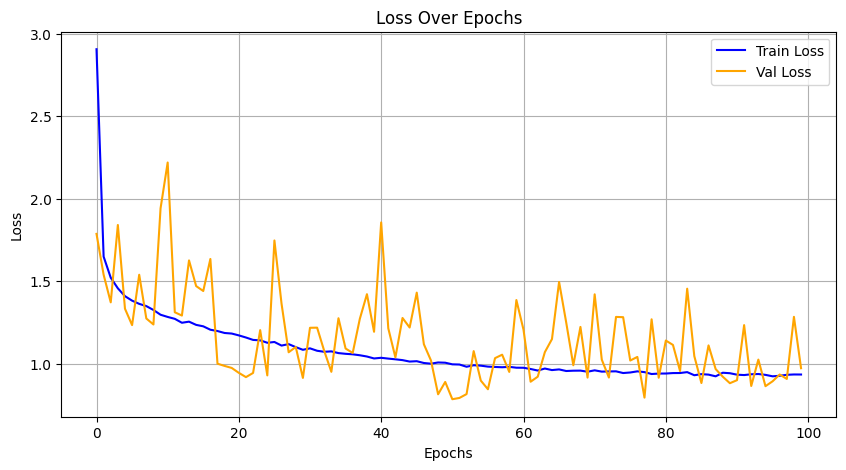

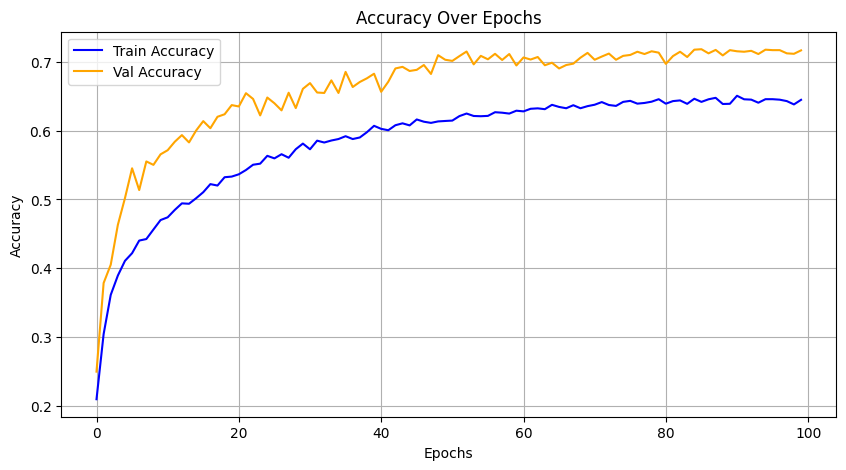

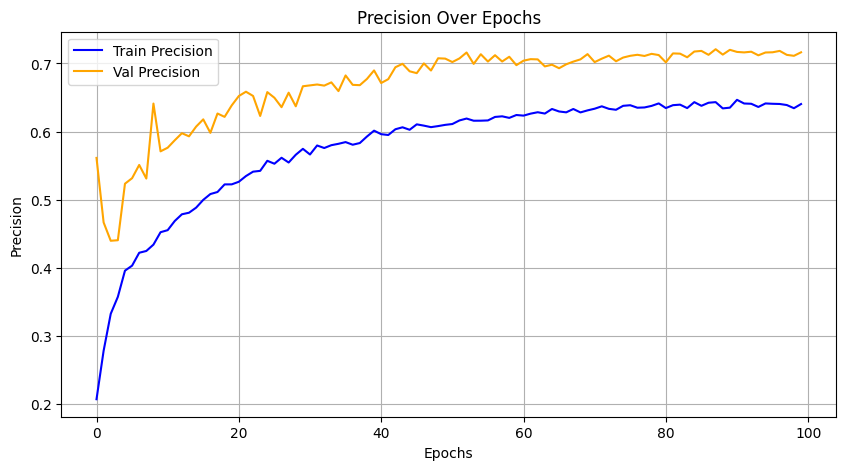

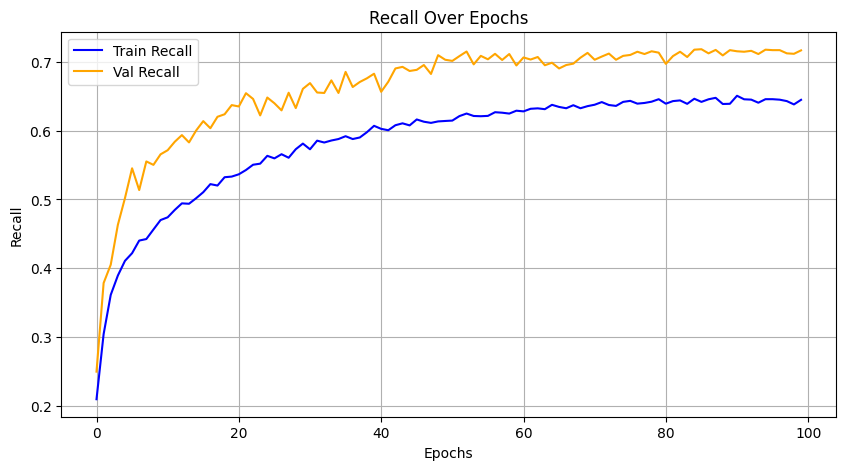

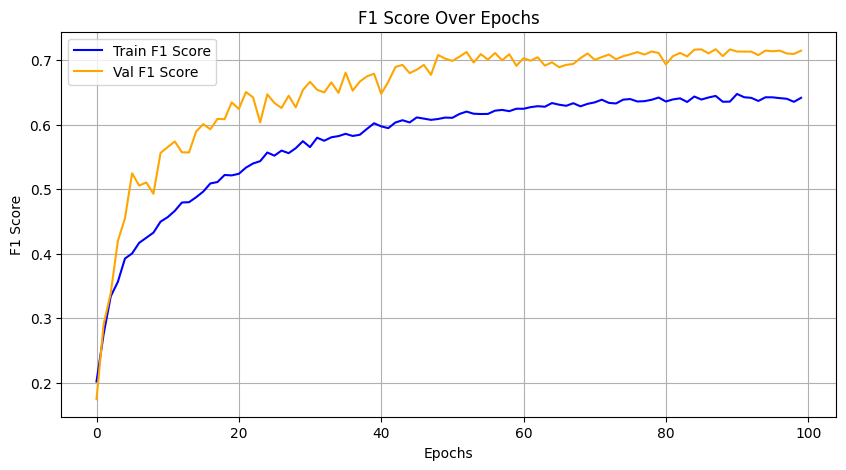

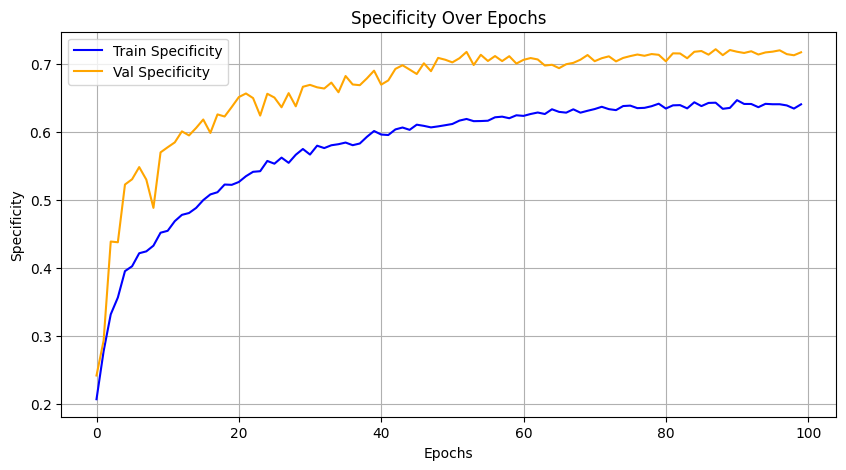

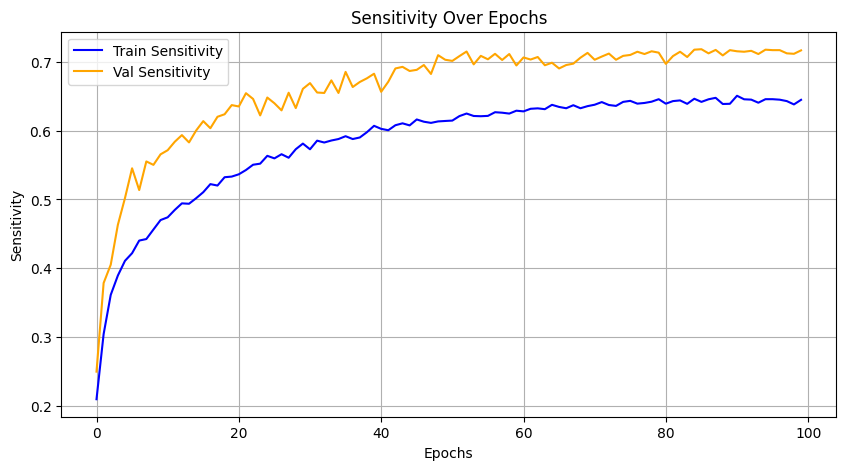

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device configuration (using both GPUs if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(weights=None)  # Ensure this line is not inside the `if` block for DataParallel
model.fc = nn.Linear(model.fc.in_features, 6)  # Modify the output for 6 classes
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Define data augmentation and transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=1.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_train/seg_train/', transform=train_transforms)
test_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_test/seg_test/', transform=test_transforms)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

# Gradient scaler for mixed precision
scaler = GradScaler()

# Initialize lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []
train_specificities, val_specificities = [], []
train_sensitivities, val_sensitivities = [], []

# Function to calculate specificity
def calculate_specificity(cm):
    tn = np.diag(cm)
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / (tn + fp + 1e-10)
    return np.mean(specificity)

# Function to train the model with mixed precision
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=80):
    model.train()
    accumulation_steps = 2  
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # Updated line
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        # Updated line: Removed the running_loss argument
        scheduler.step()  

        cm = confusion_matrix(all_labels, all_preds)
        specificity = calculate_specificity(cm)
        sensitivity = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)
        train_f1_scores.append(epoch_f1)
        train_specificities.append(specificity)
        train_sensitivities.append(sensitivity)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, '
              f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}, '
              f'Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}')

        torch.cuda.empty_cache()


def validate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    specificity = calculate_specificity(cm)
    sensitivity = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    val_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    val_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    val_specificities.append(specificity)
    val_sensitivities.append(sensitivity)

    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, '
          f'Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}, Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}')
    return val_acc

# Function to save the model checkpoints
def save_checkpoint(state, filename="checkpoint_resnet.pth"):
    torch.save(state, filename)

# Start training
num_epochs = 100
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=1)
    val_acc = validate_model(model, test_loader, criterion)

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }, filename=f"model_epoch_{epoch+1}.pth")

# Save the best model after training completion
final_model_path = "/kaggle/working/best_model_resnet.pth"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_accuracy': best_acc,
}, final_model_path)

print(f"Best model saved with accuracy: {best_acc:.4f} at {final_model_path}")

# Function to plot training and validation metrics
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(val_metrics, label=f'Val {metric_name}', color='orange')
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

# Plot metrics
plot_metrics(train_losses, val_losses, 'Loss')
plot_metrics(train_accuracies, val_accuracies, 'Accuracy')
plot_metrics(train_precisions, val_precisions, 'Precision')
plot_metrics(train_recalls, val_recalls, 'Recall')
plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')
plot_metrics(train_specificities, val_specificities, 'Specificity')
plot_metrics(train_sensitivities, val_sensitivities, 'Sensitivity')


/tmp/ipykernel_30/3568811516.py:56: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.7691, Accuracy: 0.2939, Precision: 0.2896, Recall: 0.2939, F1 Score: 0.2881, Specificity: 0.2898, Sensitivity: 0.2939


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.4144, Accuracy: 0.4383, Precision: 0.3928, Recall: 0.4383, F1 Score: 0.3641, Specificity: 0.3871, Sensitivity: 0.4383
Epoch 2/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.5146, Accuracy: 0.3759, Precision: 0.3570, Recall: 0.3759, F1 Score: 0.3568, Specificity: 0.3569, Sensitivity: 0.3759


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3348, Accuracy: 0.5030, Precision: 0.5253, Recall: 0.5030, F1 Score: 0.4271, Specificity: 0.5233, Sensitivity: 0.5030
Epoch 3/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.4342, Accuracy: 0.4096, Precision: 0.3869, Recall: 0.4096, F1 Score: 0.3866, Specificity: 0.3863, Sensitivity: 0.4096


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.3104, Accuracy: 0.4813, Precision: 0.4434, Recall: 0.4813, F1 Score: 0.4444, Specificity: 0.4371, Sensitivity: 0.4813
Epoch 4/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3710, Accuracy: 0.4404, Precision: 0.4209, Recall: 0.4404, F1 Score: 0.4201, Specificity: 0.4203, Sensitivity: 0.4404


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1238, Accuracy: 0.5500, Precision: 0.5350, Recall: 0.5500, F1 Score: 0.5073, Specificity: 0.5336, Sensitivity: 0.5500
Epoch 5/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.3318, Accuracy: 0.4624, Precision: 0.4470, Recall: 0.4624, F1 Score: 0.4480, Specificity: 0.4463, Sensitivity: 0.4624


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.1658, Accuracy: 0.5620, Precision: 0.5368, Recall: 0.5620, F1 Score: 0.5263, Specificity: 0.5301, Sensitivity: 0.5620
Epoch 6/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2711, Accuracy: 0.4888, Precision: 0.4742, Recall: 0.4888, F1 Score: 0.4747, Specificity: 0.4733, Sensitivity: 0.4888


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0269, Accuracy: 0.6180, Precision: 0.6180, Recall: 0.6180, F1 Score: 0.6088, Specificity: 0.6178, Sensitivity: 0.6180
Epoch 7/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2523, Accuracy: 0.5026, Precision: 0.4885, Recall: 0.5026, F1 Score: 0.4862, Specificity: 0.4884, Sensitivity: 0.5026


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 1.0323, Accuracy: 0.6073, Precision: 0.6057, Recall: 0.6073, F1 Score: 0.5807, Specificity: 0.6014, Sensitivity: 0.6073
Epoch 8/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.2345, Accuracy: 0.5135, Precision: 0.5015, Recall: 0.5135, F1 Score: 0.5035, Specificity: 0.5009, Sensitivity: 0.5135


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9804, Accuracy: 0.6597, Precision: 0.6582, Recall: 0.6597, F1 Score: 0.6560, Specificity: 0.6568, Sensitivity: 0.6597
Epoch 9/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1994, Accuracy: 0.5356, Precision: 0.5239, Recall: 0.5356, F1 Score: 0.5259, Specificity: 0.5231, Sensitivity: 0.5356


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9581, Accuracy: 0.6477, Precision: 0.6556, Recall: 0.6477, F1 Score: 0.6401, Specificity: 0.6560, Sensitivity: 0.6477
Epoch 10/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1828, Accuracy: 0.5435, Precision: 0.5334, Recall: 0.5435, F1 Score: 0.5357, Specificity: 0.5327, Sensitivity: 0.5435


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9731, Accuracy: 0.6470, Precision: 0.6482, Recall: 0.6470, F1 Score: 0.6324, Specificity: 0.6512, Sensitivity: 0.6470
Epoch 11/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1502, Accuracy: 0.5572, Precision: 0.5477, Recall: 0.5572, F1 Score: 0.5498, Specificity: 0.5473, Sensitivity: 0.5572


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.9202, Accuracy: 0.6593, Precision: 0.6691, Recall: 0.6593, F1 Score: 0.6491, Specificity: 0.6691, Sensitivity: 0.6593
Epoch 12/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1392, Accuracy: 0.5614, Precision: 0.5531, Recall: 0.5614, F1 Score: 0.5535, Specificity: 0.5531, Sensitivity: 0.5614


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8895, Accuracy: 0.6760, Precision: 0.6865, Recall: 0.6760, F1 Score: 0.6702, Specificity: 0.6872, Sensitivity: 0.6760
Epoch 13/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1355, Accuracy: 0.5574, Precision: 0.5483, Recall: 0.5574, F1 Score: 0.5501, Specificity: 0.5480, Sensitivity: 0.5574


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8831, Accuracy: 0.6600, Precision: 0.6577, Recall: 0.6600, F1 Score: 0.6382, Specificity: 0.6562, Sensitivity: 0.6600
Epoch 14/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.1003, Accuracy: 0.5761, Precision: 0.5670, Recall: 0.5761, F1 Score: 0.5684, Specificity: 0.5666, Sensitivity: 0.5761


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8662, Accuracy: 0.6797, Precision: 0.6896, Recall: 0.6797, F1 Score: 0.6702, Specificity: 0.6914, Sensitivity: 0.6797
Epoch 15/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0882, Accuracy: 0.5886, Precision: 0.5821, Recall: 0.5886, F1 Score: 0.5826, Specificity: 0.5819, Sensitivity: 0.5886


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8606, Accuracy: 0.6757, Precision: 0.6969, Recall: 0.6757, F1 Score: 0.6653, Specificity: 0.6993, Sensitivity: 0.6757
Epoch 16/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0810, Accuracy: 0.5858, Precision: 0.5799, Recall: 0.5858, F1 Score: 0.5811, Specificity: 0.5797, Sensitivity: 0.5858


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8391, Accuracy: 0.6893, Precision: 0.6953, Recall: 0.6893, F1 Score: 0.6827, Specificity: 0.6992, Sensitivity: 0.6893
Epoch 17/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0630, Accuracy: 0.5946, Precision: 0.5872, Recall: 0.5946, F1 Score: 0.5886, Specificity: 0.5866, Sensitivity: 0.5946


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8142, Accuracy: 0.6963, Precision: 0.7102, Recall: 0.6963, F1 Score: 0.6885, Specificity: 0.7121, Sensitivity: 0.6963
Epoch 18/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0399, Accuracy: 0.6043, Precision: 0.5988, Recall: 0.6043, F1 Score: 0.6001, Specificity: 0.5987, Sensitivity: 0.6043


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.8194, Accuracy: 0.6960, Precision: 0.7010, Recall: 0.6960, F1 Score: 0.6912, Specificity: 0.7031, Sensitivity: 0.6960
Epoch 19/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0362, Accuracy: 0.6074, Precision: 0.6013, Recall: 0.6074, F1 Score: 0.6027, Specificity: 0.6010, Sensitivity: 0.6074


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7777, Accuracy: 0.7290, Precision: 0.7349, Recall: 0.7290, F1 Score: 0.7270, Specificity: 0.7347, Sensitivity: 0.7290
Epoch 20/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0141, Accuracy: 0.6158, Precision: 0.6099, Recall: 0.6158, F1 Score: 0.6113, Specificity: 0.6100, Sensitivity: 0.6158


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7655, Accuracy: 0.7243, Precision: 0.7291, Recall: 0.7243, F1 Score: 0.7177, Specificity: 0.7303, Sensitivity: 0.7243
Epoch 21/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0145, Accuracy: 0.6140, Precision: 0.6084, Recall: 0.6140, F1 Score: 0.6090, Specificity: 0.6084, Sensitivity: 0.6140


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7354, Accuracy: 0.7347, Precision: 0.7342, Recall: 0.7347, F1 Score: 0.7318, Specificity: 0.7350, Sensitivity: 0.7347
Epoch 22/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9889, Accuracy: 0.6291, Precision: 0.6243, Recall: 0.6291, F1 Score: 0.6248, Specificity: 0.6247, Sensitivity: 0.6291


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7565, Accuracy: 0.7167, Precision: 0.7276, Recall: 0.7167, F1 Score: 0.7133, Specificity: 0.7276, Sensitivity: 0.7167
Epoch 23/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 1.0030, Accuracy: 0.6159, Precision: 0.6097, Recall: 0.6159, F1 Score: 0.6115, Specificity: 0.6095, Sensitivity: 0.6159


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7365, Accuracy: 0.7407, Precision: 0.7410, Recall: 0.7407, F1 Score: 0.7376, Specificity: 0.7427, Sensitivity: 0.7407
Epoch 24/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9817, Accuracy: 0.6309, Precision: 0.6262, Recall: 0.6309, F1 Score: 0.6268, Specificity: 0.6260, Sensitivity: 0.6309


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7545, Accuracy: 0.7260, Precision: 0.7268, Recall: 0.7260, F1 Score: 0.7218, Specificity: 0.7282, Sensitivity: 0.7260
Epoch 25/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9771, Accuracy: 0.6291, Precision: 0.6233, Recall: 0.6291, F1 Score: 0.6251, Specificity: 0.6228, Sensitivity: 0.6291


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7432, Accuracy: 0.7300, Precision: 0.7366, Recall: 0.7300, F1 Score: 0.7217, Specificity: 0.7386, Sensitivity: 0.7300
Epoch 26/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9595, Accuracy: 0.6379, Precision: 0.6326, Recall: 0.6379, F1 Score: 0.6337, Specificity: 0.6324, Sensitivity: 0.6379


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6912, Accuracy: 0.7467, Precision: 0.7490, Recall: 0.7467, F1 Score: 0.7439, Specificity: 0.7501, Sensitivity: 0.7467
Epoch 27/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9532, Accuracy: 0.6409, Precision: 0.6368, Recall: 0.6409, F1 Score: 0.6381, Specificity: 0.6367, Sensitivity: 0.6409


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7248, Accuracy: 0.7350, Precision: 0.7441, Recall: 0.7350, F1 Score: 0.7281, Specificity: 0.7451, Sensitivity: 0.7350
Epoch 28/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9429, Accuracy: 0.6469, Precision: 0.6436, Recall: 0.6469, F1 Score: 0.6442, Specificity: 0.6434, Sensitivity: 0.6469


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.7159, Accuracy: 0.7403, Precision: 0.7421, Recall: 0.7403, F1 Score: 0.7361, Specificity: 0.7419, Sensitivity: 0.7403
Epoch 29/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9376, Accuracy: 0.6444, Precision: 0.6401, Recall: 0.6444, F1 Score: 0.6414, Specificity: 0.6398, Sensitivity: 0.6444


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6704, Accuracy: 0.7627, Precision: 0.7643, Recall: 0.7627, F1 Score: 0.7599, Specificity: 0.7660, Sensitivity: 0.7627
Epoch 30/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9429, Accuracy: 0.6454, Precision: 0.6417, Recall: 0.6454, F1 Score: 0.6427, Specificity: 0.6415, Sensitivity: 0.6454


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6983, Accuracy: 0.7523, Precision: 0.7539, Recall: 0.7523, F1 Score: 0.7513, Specificity: 0.7547, Sensitivity: 0.7523
Epoch 31/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9266, Accuracy: 0.6508, Precision: 0.6476, Recall: 0.6508, F1 Score: 0.6480, Specificity: 0.6474, Sensitivity: 0.6508


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6682, Accuracy: 0.7570, Precision: 0.7592, Recall: 0.7570, F1 Score: 0.7562, Specificity: 0.7599, Sensitivity: 0.7570
Epoch 32/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9197, Accuracy: 0.6559, Precision: 0.6524, Recall: 0.6559, F1 Score: 0.6536, Specificity: 0.6521, Sensitivity: 0.6559


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6799, Accuracy: 0.7537, Precision: 0.7564, Recall: 0.7537, F1 Score: 0.7520, Specificity: 0.7576, Sensitivity: 0.7537
Epoch 33/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9031, Accuracy: 0.6614, Precision: 0.6585, Recall: 0.6614, F1 Score: 0.6596, Specificity: 0.6583, Sensitivity: 0.6614


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6534, Accuracy: 0.7717, Precision: 0.7716, Recall: 0.7717, F1 Score: 0.7709, Specificity: 0.7723, Sensitivity: 0.7717
Epoch 34/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9017, Accuracy: 0.6623, Precision: 0.6585, Recall: 0.6623, F1 Score: 0.6594, Specificity: 0.6586, Sensitivity: 0.6623


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6583, Accuracy: 0.7640, Precision: 0.7762, Recall: 0.7640, F1 Score: 0.7643, Specificity: 0.7760, Sensitivity: 0.7640
Epoch 35/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9006, Accuracy: 0.6621, Precision: 0.6590, Recall: 0.6621, F1 Score: 0.6600, Specificity: 0.6590, Sensitivity: 0.6621


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6675, Accuracy: 0.7623, Precision: 0.7675, Recall: 0.7623, F1 Score: 0.7617, Specificity: 0.7669, Sensitivity: 0.7623
Epoch 36/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.9007, Accuracy: 0.6623, Precision: 0.6590, Recall: 0.6623, F1 Score: 0.6602, Specificity: 0.6590, Sensitivity: 0.6623


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6432, Accuracy: 0.7693, Precision: 0.7718, Recall: 0.7693, F1 Score: 0.7674, Specificity: 0.7733, Sensitivity: 0.7693
Epoch 37/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8804, Accuracy: 0.6677, Precision: 0.6657, Recall: 0.6677, F1 Score: 0.6661, Specificity: 0.6656, Sensitivity: 0.6677


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6572, Accuracy: 0.7650, Precision: 0.7702, Recall: 0.7650, F1 Score: 0.7619, Specificity: 0.7708, Sensitivity: 0.7650
Epoch 38/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8873, Accuracy: 0.6683, Precision: 0.6655, Recall: 0.6683, F1 Score: 0.6665, Specificity: 0.6653, Sensitivity: 0.6683


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6497, Accuracy: 0.7687, Precision: 0.7728, Recall: 0.7687, F1 Score: 0.7660, Specificity: 0.7724, Sensitivity: 0.7687
Epoch 39/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8746, Accuracy: 0.6747, Precision: 0.6719, Recall: 0.6747, F1 Score: 0.6730, Specificity: 0.6715, Sensitivity: 0.6747


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6501, Accuracy: 0.7693, Precision: 0.7738, Recall: 0.7693, F1 Score: 0.7668, Specificity: 0.7756, Sensitivity: 0.7693
Epoch 40/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8833, Accuracy: 0.6658, Precision: 0.6624, Recall: 0.6658, F1 Score: 0.6631, Specificity: 0.6623, Sensitivity: 0.6658


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6078, Accuracy: 0.7807, Precision: 0.7798, Recall: 0.7807, F1 Score: 0.7799, Specificity: 0.7807, Sensitivity: 0.7807
Epoch 41/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8670, Accuracy: 0.6764, Precision: 0.6733, Recall: 0.6764, F1 Score: 0.6743, Specificity: 0.6732, Sensitivity: 0.6764


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6260, Accuracy: 0.7713, Precision: 0.7728, Recall: 0.7713, F1 Score: 0.7702, Specificity: 0.7734, Sensitivity: 0.7713
Epoch 42/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8572, Accuracy: 0.6798, Precision: 0.6774, Recall: 0.6798, F1 Score: 0.6784, Specificity: 0.6773, Sensitivity: 0.6798


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6247, Accuracy: 0.7707, Precision: 0.7705, Recall: 0.7707, F1 Score: 0.7687, Specificity: 0.7704, Sensitivity: 0.7707
Epoch 43/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8630, Accuracy: 0.6749, Precision: 0.6719, Recall: 0.6749, F1 Score: 0.6729, Specificity: 0.6721, Sensitivity: 0.6749


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6084, Accuracy: 0.7847, Precision: 0.7866, Recall: 0.7847, F1 Score: 0.7839, Specificity: 0.7875, Sensitivity: 0.7847
Epoch 44/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8547, Accuracy: 0.6777, Precision: 0.6741, Recall: 0.6777, F1 Score: 0.6751, Specificity: 0.6742, Sensitivity: 0.6777


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6150, Accuracy: 0.7727, Precision: 0.7770, Recall: 0.7727, F1 Score: 0.7705, Specificity: 0.7777, Sensitivity: 0.7727
Epoch 45/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8554, Accuracy: 0.6816, Precision: 0.6787, Recall: 0.6816, F1 Score: 0.6796, Specificity: 0.6788, Sensitivity: 0.6816


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6035, Accuracy: 0.7840, Precision: 0.7877, Recall: 0.7840, F1 Score: 0.7829, Specificity: 0.7885, Sensitivity: 0.7840
Epoch 46/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8510, Accuracy: 0.6819, Precision: 0.6793, Recall: 0.6819, F1 Score: 0.6800, Specificity: 0.6792, Sensitivity: 0.6819


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6143, Accuracy: 0.7767, Precision: 0.7843, Recall: 0.7767, F1 Score: 0.7744, Specificity: 0.7855, Sensitivity: 0.7767
Epoch 47/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8305, Accuracy: 0.6879, Precision: 0.6858, Recall: 0.6879, F1 Score: 0.6864, Specificity: 0.6859, Sensitivity: 0.6879


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5798, Accuracy: 0.7853, Precision: 0.7892, Recall: 0.7853, F1 Score: 0.7852, Specificity: 0.7900, Sensitivity: 0.7853
Epoch 48/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8334, Accuracy: 0.6911, Precision: 0.6883, Recall: 0.6911, F1 Score: 0.6889, Specificity: 0.6885, Sensitivity: 0.6911


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.6239, Accuracy: 0.7823, Precision: 0.7868, Recall: 0.7823, F1 Score: 0.7803, Specificity: 0.7868, Sensitivity: 0.7823
Epoch 49/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8350, Accuracy: 0.6889, Precision: 0.6854, Recall: 0.6889, F1 Score: 0.6864, Specificity: 0.6855, Sensitivity: 0.6889


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5780, Accuracy: 0.7907, Precision: 0.7924, Recall: 0.7907, F1 Score: 0.7906, Specificity: 0.7923, Sensitivity: 0.7907
Epoch 50/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8294, Accuracy: 0.6902, Precision: 0.6872, Recall: 0.6902, F1 Score: 0.6883, Specificity: 0.6872, Sensitivity: 0.6902


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5818, Accuracy: 0.7897, Precision: 0.7912, Recall: 0.7897, F1 Score: 0.7889, Specificity: 0.7909, Sensitivity: 0.7897
Epoch 51/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8284, Accuracy: 0.6890, Precision: 0.6870, Recall: 0.6890, F1 Score: 0.6876, Specificity: 0.6869, Sensitivity: 0.6890


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5853, Accuracy: 0.7860, Precision: 0.7894, Recall: 0.7860, F1 Score: 0.7834, Specificity: 0.7903, Sensitivity: 0.7860
Epoch 52/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8336, Accuracy: 0.6945, Precision: 0.6923, Recall: 0.6945, F1 Score: 0.6928, Specificity: 0.6924, Sensitivity: 0.6945


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5889, Accuracy: 0.7857, Precision: 0.7885, Recall: 0.7857, F1 Score: 0.7833, Specificity: 0.7899, Sensitivity: 0.7857
Epoch 53/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8234, Accuracy: 0.6919, Precision: 0.6899, Recall: 0.6919, F1 Score: 0.6904, Specificity: 0.6901, Sensitivity: 0.6919


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5671, Accuracy: 0.7920, Precision: 0.7938, Recall: 0.7920, F1 Score: 0.7903, Specificity: 0.7959, Sensitivity: 0.7920
Epoch 54/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8223, Accuracy: 0.6952, Precision: 0.6927, Recall: 0.6952, F1 Score: 0.6935, Specificity: 0.6928, Sensitivity: 0.6952


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5981, Accuracy: 0.7840, Precision: 0.7874, Recall: 0.7840, F1 Score: 0.7839, Specificity: 0.7897, Sensitivity: 0.7840
Epoch 55/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8171, Accuracy: 0.6922, Precision: 0.6897, Recall: 0.6922, F1 Score: 0.6907, Specificity: 0.6898, Sensitivity: 0.6922


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5797, Accuracy: 0.7923, Precision: 0.7933, Recall: 0.7923, F1 Score: 0.7916, Specificity: 0.7936, Sensitivity: 0.7923
Epoch 56/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8138, Accuracy: 0.6993, Precision: 0.6968, Recall: 0.6993, F1 Score: 0.6974, Specificity: 0.6970, Sensitivity: 0.6993


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5807, Accuracy: 0.7930, Precision: 0.7940, Recall: 0.7930, F1 Score: 0.7917, Specificity: 0.7945, Sensitivity: 0.7930
Epoch 57/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8117, Accuracy: 0.6983, Precision: 0.6960, Recall: 0.6983, F1 Score: 0.6967, Specificity: 0.6959, Sensitivity: 0.6983


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5683, Accuracy: 0.7933, Precision: 0.7940, Recall: 0.7933, F1 Score: 0.7920, Specificity: 0.7947, Sensitivity: 0.7933
Epoch 58/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8101, Accuracy: 0.6952, Precision: 0.6928, Recall: 0.6952, F1 Score: 0.6936, Specificity: 0.6931, Sensitivity: 0.6952


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5900, Accuracy: 0.7920, Precision: 0.7953, Recall: 0.7920, F1 Score: 0.7900, Specificity: 0.7973, Sensitivity: 0.7920
Epoch 59/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8124, Accuracy: 0.7015, Precision: 0.6988, Recall: 0.7015, F1 Score: 0.6994, Specificity: 0.6992, Sensitivity: 0.7015


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5763, Accuracy: 0.7943, Precision: 0.7966, Recall: 0.7943, F1 Score: 0.7935, Specificity: 0.7970, Sensitivity: 0.7943
Epoch 60/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8213, Accuracy: 0.6976, Precision: 0.6948, Recall: 0.6976, F1 Score: 0.6957, Specificity: 0.6947, Sensitivity: 0.6976


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5705, Accuracy: 0.7940, Precision: 0.7950, Recall: 0.7940, F1 Score: 0.7929, Specificity: 0.7962, Sensitivity: 0.7940
Epoch 61/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8018, Accuracy: 0.6987, Precision: 0.6964, Recall: 0.6987, F1 Score: 0.6972, Specificity: 0.6967, Sensitivity: 0.6987


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5767, Accuracy: 0.7887, Precision: 0.7897, Recall: 0.7887, F1 Score: 0.7878, Specificity: 0.7909, Sensitivity: 0.7887
Epoch 62/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8077, Accuracy: 0.7009, Precision: 0.6984, Recall: 0.7009, F1 Score: 0.6990, Specificity: 0.6984, Sensitivity: 0.7009


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5682, Accuracy: 0.7960, Precision: 0.7986, Recall: 0.7960, F1 Score: 0.7941, Specificity: 0.7996, Sensitivity: 0.7960
Epoch 63/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8014, Accuracy: 0.7043, Precision: 0.7019, Recall: 0.7043, F1 Score: 0.7027, Specificity: 0.7021, Sensitivity: 0.7043


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5611, Accuracy: 0.7957, Precision: 0.7972, Recall: 0.7957, F1 Score: 0.7949, Specificity: 0.7980, Sensitivity: 0.7957
Epoch 64/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8039, Accuracy: 0.6997, Precision: 0.6972, Recall: 0.6997, F1 Score: 0.6981, Specificity: 0.6974, Sensitivity: 0.6997


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5603, Accuracy: 0.8007, Precision: 0.8032, Recall: 0.8007, F1 Score: 0.7994, Specificity: 0.8038, Sensitivity: 0.8007
Epoch 65/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8040, Accuracy: 0.7041, Precision: 0.7020, Recall: 0.7041, F1 Score: 0.7027, Specificity: 0.7022, Sensitivity: 0.7041


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5677, Accuracy: 0.7947, Precision: 0.7977, Recall: 0.7947, F1 Score: 0.7935, Specificity: 0.7975, Sensitivity: 0.7947
Epoch 66/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7959, Accuracy: 0.7002, Precision: 0.6979, Recall: 0.7002, F1 Score: 0.6985, Specificity: 0.6982, Sensitivity: 0.7002


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5598, Accuracy: 0.7930, Precision: 0.7943, Recall: 0.7930, F1 Score: 0.7923, Specificity: 0.7944, Sensitivity: 0.7930
Epoch 67/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7901, Accuracy: 0.7034, Precision: 0.7015, Recall: 0.7034, F1 Score: 0.7022, Specificity: 0.7016, Sensitivity: 0.7034


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5571, Accuracy: 0.8017, Precision: 0.8020, Recall: 0.8017, F1 Score: 0.8005, Specificity: 0.8031, Sensitivity: 0.8017
Epoch 68/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7869, Accuracy: 0.7061, Precision: 0.7038, Recall: 0.7061, F1 Score: 0.7045, Specificity: 0.7041, Sensitivity: 0.7061


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5464, Accuracy: 0.8020, Precision: 0.8023, Recall: 0.8020, F1 Score: 0.8014, Specificity: 0.8035, Sensitivity: 0.8020
Epoch 69/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7936, Accuracy: 0.7048, Precision: 0.7025, Recall: 0.7048, F1 Score: 0.7032, Specificity: 0.7027, Sensitivity: 0.7048


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5494, Accuracy: 0.8003, Precision: 0.8029, Recall: 0.8003, F1 Score: 0.7987, Specificity: 0.8038, Sensitivity: 0.8003
Epoch 70/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7911, Accuracy: 0.7059, Precision: 0.7032, Recall: 0.7059, F1 Score: 0.7039, Specificity: 0.7034, Sensitivity: 0.7059


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5464, Accuracy: 0.7983, Precision: 0.7996, Recall: 0.7983, F1 Score: 0.7972, Specificity: 0.8007, Sensitivity: 0.7983
Epoch 71/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7954, Accuracy: 0.7062, Precision: 0.7036, Recall: 0.7062, F1 Score: 0.7045, Specificity: 0.7038, Sensitivity: 0.7062


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5541, Accuracy: 0.7990, Precision: 0.8006, Recall: 0.7990, F1 Score: 0.7984, Specificity: 0.8012, Sensitivity: 0.7990
Epoch 72/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8020, Accuracy: 0.7024, Precision: 0.7000, Recall: 0.7024, F1 Score: 0.7008, Specificity: 0.7003, Sensitivity: 0.7024


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5537, Accuracy: 0.7990, Precision: 0.8009, Recall: 0.7990, F1 Score: 0.7988, Specificity: 0.8008, Sensitivity: 0.7990
Epoch 73/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7850, Accuracy: 0.7103, Precision: 0.7078, Recall: 0.7103, F1 Score: 0.7084, Specificity: 0.7080, Sensitivity: 0.7103


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5501, Accuracy: 0.7947, Precision: 0.7975, Recall: 0.7947, F1 Score: 0.7939, Specificity: 0.7977, Sensitivity: 0.7947
Epoch 74/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7951, Accuracy: 0.7048, Precision: 0.7033, Recall: 0.7048, F1 Score: 0.7035, Specificity: 0.7036, Sensitivity: 0.7048


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5563, Accuracy: 0.8003, Precision: 0.8037, Recall: 0.8003, F1 Score: 0.7997, Specificity: 0.8050, Sensitivity: 0.8003
Epoch 75/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.8000, Accuracy: 0.7037, Precision: 0.7019, Recall: 0.7037, F1 Score: 0.7024, Specificity: 0.7022, Sensitivity: 0.7037


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5536, Accuracy: 0.8003, Precision: 0.8012, Recall: 0.8003, F1 Score: 0.7996, Specificity: 0.8017, Sensitivity: 0.8003
Epoch 76/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7897, Accuracy: 0.6999, Precision: 0.6967, Recall: 0.6999, F1 Score: 0.6977, Specificity: 0.6967, Sensitivity: 0.6999


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5621, Accuracy: 0.7977, Precision: 0.7995, Recall: 0.7977, F1 Score: 0.7964, Specificity: 0.7999, Sensitivity: 0.7977
Epoch 77/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7821, Accuracy: 0.7081, Precision: 0.7059, Recall: 0.7081, F1 Score: 0.7066, Specificity: 0.7061, Sensitivity: 0.7081


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5534, Accuracy: 0.8003, Precision: 0.8014, Recall: 0.8003, F1 Score: 0.8000, Specificity: 0.8022, Sensitivity: 0.8003
Epoch 78/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7825, Accuracy: 0.7076, Precision: 0.7053, Recall: 0.7076, F1 Score: 0.7061, Specificity: 0.7056, Sensitivity: 0.7076


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5584, Accuracy: 0.7963, Precision: 0.7974, Recall: 0.7963, F1 Score: 0.7961, Specificity: 0.7982, Sensitivity: 0.7963
Epoch 79/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7837, Accuracy: 0.7106, Precision: 0.7084, Recall: 0.7106, F1 Score: 0.7092, Specificity: 0.7085, Sensitivity: 0.7106


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5491, Accuracy: 0.8003, Precision: 0.8019, Recall: 0.8003, F1 Score: 0.8002, Specificity: 0.8029, Sensitivity: 0.8003
Epoch 80/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7764, Accuracy: 0.7131, Precision: 0.7113, Recall: 0.7131, F1 Score: 0.7119, Specificity: 0.7117, Sensitivity: 0.7131


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5532, Accuracy: 0.7963, Precision: 0.7986, Recall: 0.7963, F1 Score: 0.7958, Specificity: 0.7994, Sensitivity: 0.7963
Epoch 81/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7877, Accuracy: 0.7074, Precision: 0.7056, Recall: 0.7074, F1 Score: 0.7062, Specificity: 0.7059, Sensitivity: 0.7074


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5540, Accuracy: 0.8007, Precision: 0.8020, Recall: 0.8007, F1 Score: 0.8001, Specificity: 0.8021, Sensitivity: 0.8007
Epoch 82/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7912, Accuracy: 0.7082, Precision: 0.7063, Recall: 0.7082, F1 Score: 0.7070, Specificity: 0.7063, Sensitivity: 0.7082


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5536, Accuracy: 0.7987, Precision: 0.8010, Recall: 0.7987, F1 Score: 0.7979, Specificity: 0.8010, Sensitivity: 0.7987
Epoch 83/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7836, Accuracy: 0.7072, Precision: 0.7053, Recall: 0.7072, F1 Score: 0.7061, Specificity: 0.7055, Sensitivity: 0.7072


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5543, Accuracy: 0.7950, Precision: 0.7966, Recall: 0.7950, F1 Score: 0.7936, Specificity: 0.7968, Sensitivity: 0.7950
Epoch 84/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7925, Accuracy: 0.7056, Precision: 0.7035, Recall: 0.7056, F1 Score: 0.7040, Specificity: 0.7036, Sensitivity: 0.7056


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5520, Accuracy: 0.8003, Precision: 0.8020, Recall: 0.8003, F1 Score: 0.7992, Specificity: 0.8025, Sensitivity: 0.8003
Epoch 85/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7831, Accuracy: 0.7071, Precision: 0.7051, Recall: 0.7071, F1 Score: 0.7059, Specificity: 0.7055, Sensitivity: 0.7071


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5436, Accuracy: 0.7990, Precision: 0.7991, Recall: 0.7990, F1 Score: 0.7983, Specificity: 0.8004, Sensitivity: 0.7990
Epoch 86/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7916, Accuracy: 0.7053, Precision: 0.7032, Recall: 0.7053, F1 Score: 0.7040, Specificity: 0.7031, Sensitivity: 0.7053


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5550, Accuracy: 0.7953, Precision: 0.7968, Recall: 0.7953, F1 Score: 0.7947, Specificity: 0.7982, Sensitivity: 0.7953
Epoch 87/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7828, Accuracy: 0.7103, Precision: 0.7083, Recall: 0.7103, F1 Score: 0.7090, Specificity: 0.7084, Sensitivity: 0.7103


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5716, Accuracy: 0.7960, Precision: 0.8000, Recall: 0.7960, F1 Score: 0.7950, Specificity: 0.7994, Sensitivity: 0.7960
Epoch 88/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7760, Accuracy: 0.7093, Precision: 0.7071, Recall: 0.7093, F1 Score: 0.7078, Specificity: 0.7071, Sensitivity: 0.7093


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5706, Accuracy: 0.7913, Precision: 0.7951, Recall: 0.7913, F1 Score: 0.7911, Specificity: 0.7959, Sensitivity: 0.7913
Epoch 89/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7837, Accuracy: 0.7090, Precision: 0.7073, Recall: 0.7090, F1 Score: 0.7078, Specificity: 0.7076, Sensitivity: 0.7090


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5626, Accuracy: 0.7957, Precision: 0.7989, Recall: 0.7957, F1 Score: 0.7936, Specificity: 0.8008, Sensitivity: 0.7957
Epoch 90/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7801, Accuracy: 0.7103, Precision: 0.7078, Recall: 0.7103, F1 Score: 0.7086, Specificity: 0.7080, Sensitivity: 0.7103


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5600, Accuracy: 0.7993, Precision: 0.8011, Recall: 0.7993, F1 Score: 0.7986, Specificity: 0.8020, Sensitivity: 0.7993
Epoch 91/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7735, Accuracy: 0.7116, Precision: 0.7092, Recall: 0.7116, F1 Score: 0.7100, Specificity: 0.7092, Sensitivity: 0.7116


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5588, Accuracy: 0.7933, Precision: 0.7961, Recall: 0.7933, F1 Score: 0.7931, Specificity: 0.7968, Sensitivity: 0.7933
Epoch 92/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7804, Accuracy: 0.7126, Precision: 0.7105, Recall: 0.7126, F1 Score: 0.7112, Specificity: 0.7108, Sensitivity: 0.7126


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5525, Accuracy: 0.8000, Precision: 0.8018, Recall: 0.8000, F1 Score: 0.7991, Specificity: 0.8025, Sensitivity: 0.8000
Epoch 93/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7790, Accuracy: 0.7112, Precision: 0.7092, Recall: 0.7112, F1 Score: 0.7098, Specificity: 0.7095, Sensitivity: 0.7112


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5422, Accuracy: 0.8033, Precision: 0.8036, Recall: 0.8033, F1 Score: 0.8026, Specificity: 0.8045, Sensitivity: 0.8033
Epoch 94/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7750, Accuracy: 0.7129, Precision: 0.7104, Recall: 0.7129, F1 Score: 0.7112, Specificity: 0.7105, Sensitivity: 0.7129


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5551, Accuracy: 0.7990, Precision: 0.8009, Recall: 0.7990, F1 Score: 0.7980, Specificity: 0.8017, Sensitivity: 0.7990
Epoch 95/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7810, Accuracy: 0.7091, Precision: 0.7069, Recall: 0.7091, F1 Score: 0.7076, Specificity: 0.7071, Sensitivity: 0.7091


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5485, Accuracy: 0.8030, Precision: 0.8039, Recall: 0.8030, F1 Score: 0.8020, Specificity: 0.8045, Sensitivity: 0.8030
Epoch 96/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7786, Accuracy: 0.7103, Precision: 0.7084, Recall: 0.7103, F1 Score: 0.7091, Specificity: 0.7087, Sensitivity: 0.7103


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5373, Accuracy: 0.8027, Precision: 0.8032, Recall: 0.8027, F1 Score: 0.8023, Specificity: 0.8039, Sensitivity: 0.8027
Epoch 97/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7779, Accuracy: 0.7116, Precision: 0.7099, Recall: 0.7116, F1 Score: 0.7102, Specificity: 0.7104, Sensitivity: 0.7116


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5427, Accuracy: 0.8060, Precision: 0.8065, Recall: 0.8060, F1 Score: 0.8050, Specificity: 0.8074, Sensitivity: 0.8060
Epoch 98/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7852, Accuracy: 0.7068, Precision: 0.7046, Recall: 0.7068, F1 Score: 0.7051, Specificity: 0.7051, Sensitivity: 0.7068


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5510, Accuracy: 0.8027, Precision: 0.8049, Recall: 0.8027, F1 Score: 0.8016, Specificity: 0.8048, Sensitivity: 0.8027
Epoch 99/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7797, Accuracy: 0.7113, Precision: 0.7089, Recall: 0.7113, F1 Score: 0.7096, Specificity: 0.7092, Sensitivity: 0.7113


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5443, Accuracy: 0.8017, Precision: 0.8023, Recall: 0.8017, F1 Score: 0.8015, Specificity: 0.8029, Sensitivity: 0.8017
Epoch 100/100


/tmp/ipykernel_30/3568811516.py:90: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch 1/1, Loss: 0.7789, Accuracy: 0.7077, Precision: 0.7056, Recall: 0.7077, F1 Score: 0.7062, Specificity: 0.7059, Sensitivity: 0.7077


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Validation Loss: 0.5441, Accuracy: 0.8013, Precision: 0.8022, Recall: 0.8013, F1 Score: 0.8007, Specificity: 0.8029, Sensitivity: 0.8013
Best model saved with accuracy: 0.8060 at /kaggle/working/best_model_efficientnet_b0.pth


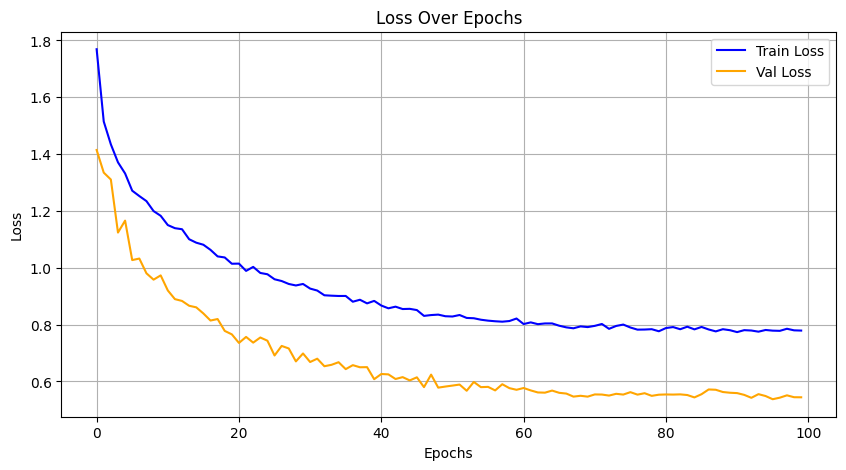

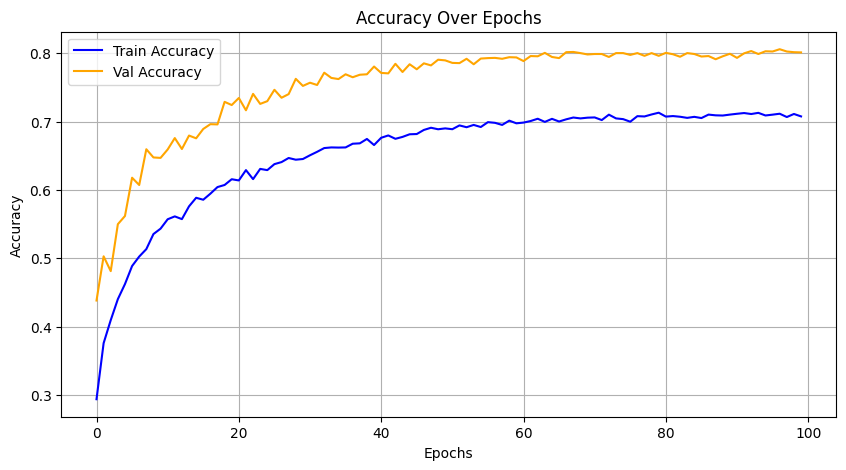

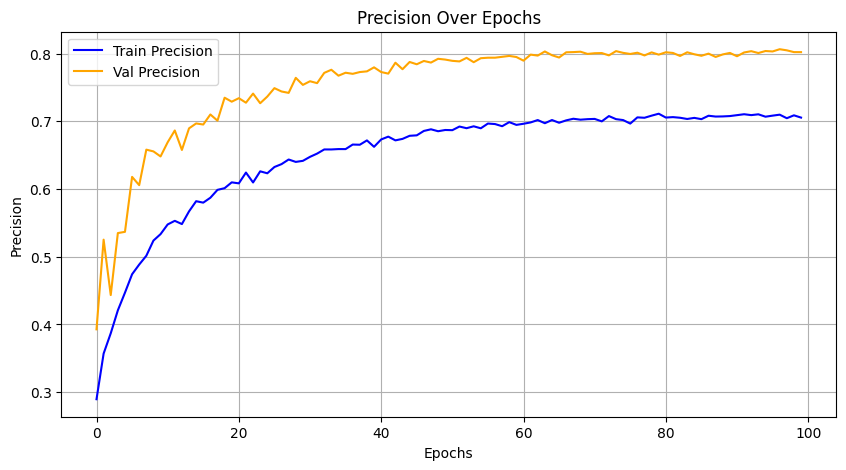

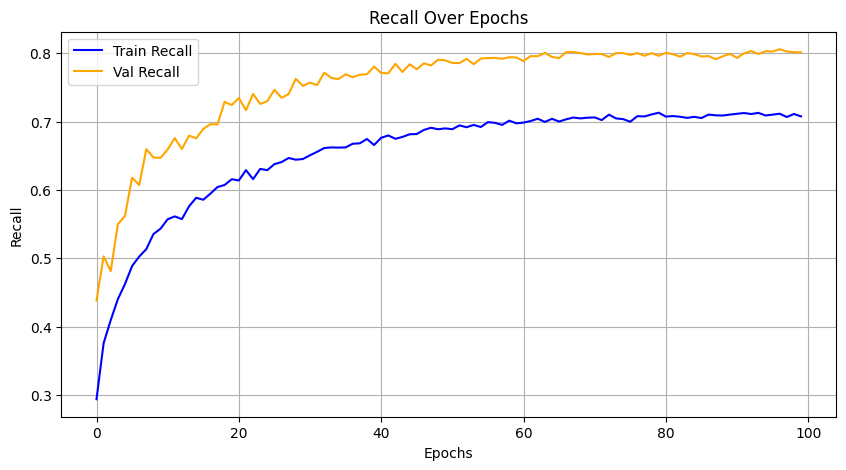

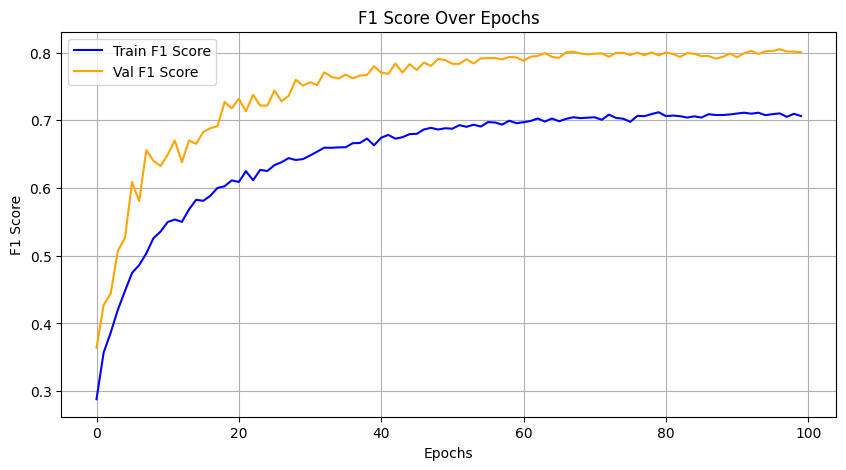

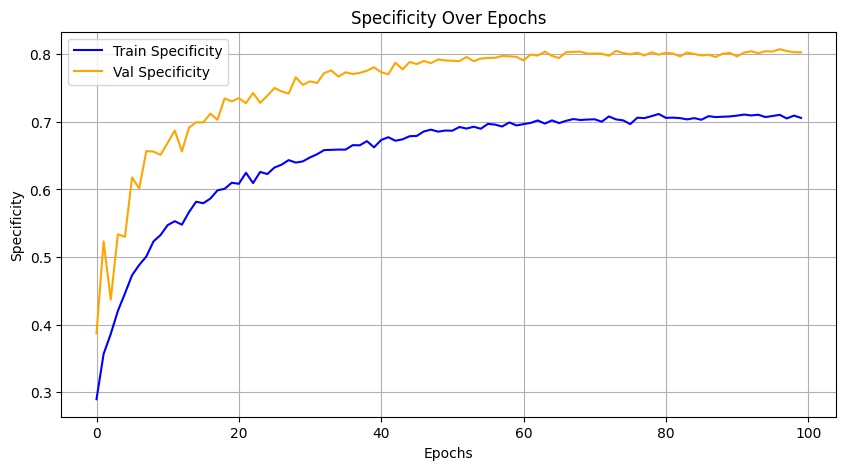

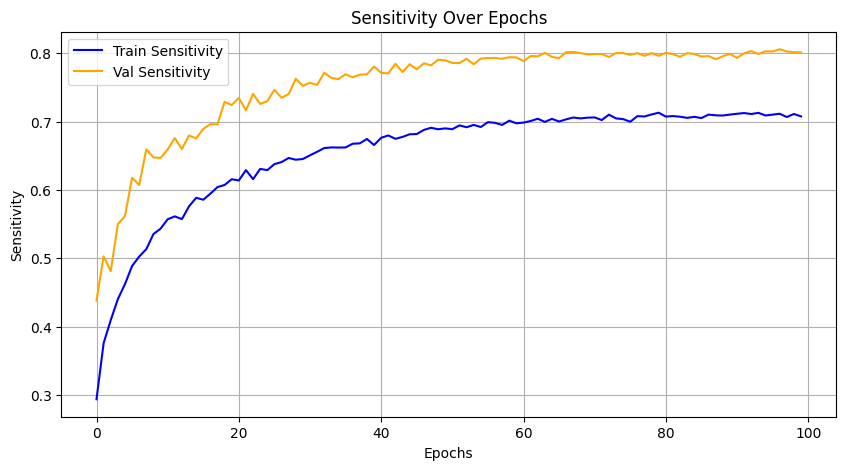

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Device configuration (using both GPUs if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the EfficientNet B0 model
model = models.efficientnet_b0(weights=None)  # Initialize EfficientNet B0 without pretrained weights
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)  # Modify the output for 6 classes
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Define data augmentation and transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.RandomResizedCrop(224),
    transforms.ColorJitter(brightness=1.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the datasets using ImageFolder
train_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_train/seg_train/', transform=train_transforms)
test_dataset = ImageFolder(root='/kaggle/input/intel-image-classification/seg_test/seg_test/', transform=test_transforms)

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.045, momentum=0.9)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)

# Gradient scaler for mixed precision
scaler = GradScaler()

# Initialize lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []
train_specificities, val_specificities = [], []
train_sensitivities, val_sensitivities = [], []

# Function to calculate specificity
def calculate_specificity(cm):
    tn = np.diag(cm)
    fp = np.sum(cm, axis=0) - np.diag(cm)
    specificity = tn / (tn + fp + 1e-10)
    return np.mean(specificity)

# Function to train the model with mixed precision
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=80):
    model.train()
    accumulation_steps = 2  
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss = loss / accumulation_steps
            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        scheduler.step()

        cm = confusion_matrix(all_labels, all_preds)
        specificity = calculate_specificity(cm)
        sensitivity = recall_score(all_labels, all_preds, average='weighted', zero_division=1)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
        epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)
        train_f1_scores.append(epoch_f1)
        train_specificities.append(specificity)
        train_sensitivities.append(sensitivity)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, '
              f'Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}, '
              f'Specificity: {specificity:.4f}, Sensitivity: {sensitivity:.4f}')

        torch.cuda.empty_cache()

# Validation, saving, and plotting functions remain the same as in your provided code

# Start training
num_epochs = 100
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=1)
    val_acc = validate_model(model, test_loader, criterion)

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    
    save_checkpoint({
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'best_acc': best_acc,
        'optimizer': optimizer.state_dict(),
    }, filename=f"model_epoch_{epoch+1}.pth")

# Save the best model after training completion
final_model_path = "/kaggle/working/best_model_efficientnet_b0.pth"
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_accuracy': best_acc,
}, final_model_path)

print(f"Best model saved with accuracy: {best_acc:.4f} at {final_model_path}")

# Plot metrics function remains the same

# Function to plot training and validation metrics
def plot_metrics(train_metrics, val_metrics, metric_name):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(val_metrics, label=f'Val {metric_name}', color='orange')
    plt.title(f'{metric_name} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

# Plot metrics
plot_metrics(train_losses, val_losses, 'Loss')
plot_metrics(train_accuracies, val_accuracies, 'Accuracy')
plot_metrics(train_precisions, val_precisions, 'Precision')
plot_metrics(train_recalls, val_recalls, 'Recall')
plot_metrics(train_f1_scores, val_f1_scores, 'F1 Score')
plot_metrics(train_specificities, val_specificities, 'Specificity')
plot_metrics(train_sensitivities, val_sensitivities, 'Sensitivity')
